<a href="https://colab.research.google.com/github/kamila-in-dataland/The-Office-Project/blob/main/Analiza_danych_dotyczacych_serialu_The_Office.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analiza danych dotyczących serialu "The Office"

"The Office" to amerykański komediowy serial telewizyjny, który bazował na brytyjskiej wersji serialu o tym samym tytule. Miał on premierę w 2005 roku i trwał przez dziewięć sezonów - do 2013 roku.

Akcja serialu "The Office" toczy się w biurze firmy zajmującej się sprzedażą papieru - Dunder Mifflin Paper Company w Scranton w Pensylwanii. Serial ma postać fikcyjnego dokumentu skupiającego się na relacjonowaniu codziennego życia pracowników biura. Jedną z głównych postaci jest grany przez Steve'a Carella Michael Scott, który pełni funkcję nieco niekonwencjonalnego menedżera oddziału firmy.

Serial "The Office" jest znany ze swojego specyficznego stylu komediowego, opartego na żartach sytuacyjnych i niezręcznych dialogach. Sitcom zdobył ogromną popularność i stał się kultowy, zarówno w Stanach Zjednoczonych, jak i na całym świecie. Przez to, że jest on kręcony w stylu mockumentary (udaje film dokumentalny), jego treść odnosi się często do rzeczywistości np. krachu giełdowego, załamania sprzedaży produktów papierniczych czy też niestabilnej sytuacji na rynku.

W swoim projekcie chciałabym skupić się na analizie danych dotyczących  serialu, tj. ocenić zmiany w jego popularności na przestrzeni lat z uwzględnieniem często kontrowersyjnych decyzji reżyserów, takich jak wykluczenie z serialu Steve'a Carella - przez wielu uznawanego za aktora będącego głównym filarem serialu, oraz przeprowadzić analizę scenariusza serialu pod kątem np. najczęściej występujących słów.


# Zaimportowanie potrzebnych bibliotek

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import warnings
warnings.filterwarnings('ignore')
nltk.download('popular')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import bigrams
from nltk import ngrams
from textblob import TextBlob

# Pierwszy zestaw danych

## Zaimportowanie pierwszego zestawu danych i jego wstępna analiza

Początkowo zamierzałam skorzystać z gotowego zestawu danych, który pobrałam ze strony kaggle.com: https://www.kaggle.com/datasets/nehaprabhavalkar/the-office-dataset

Najpierw jednak postanowiłam ocenić go pod kątem użyteczności do analizy danych.

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
#Wyświetlenie pierwszych 3 wierszy ramki danych w celu zapoznania się z jej zawartością
office1 = pd.read_csv("the_office_series.csv")
office1.head(3)

,Unnamed: 0,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date,GuestStars,Director,Writers
0,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.2,23,24 March 2005,NaN,Ken Kwapis,Ricky Gervais |Stephen Merchant and Greg Daniels
1,1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.0,23,29 March 2005,NaN,Ken Kwapis,B. J. Novak
2,2,1,Health Care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.8,22,5 April 2005,NaN,Ken Whittingham,Paul Lieberstein


Zgodnie z informacjami podanymi na stronie kaggle.com zestaw danych był aktualizowany ostatni raz 3 lata temu - średnie oceny poszczególnych odcinków i łączne liczby głosów nie są zatem już aktualne i na pewno nie zaszkodziłoby pobranie nowszych danych.

In [ ]:
#Wyświetlenie ogólnych informacji o zbiorze danych
office1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    188 non-null    int64  
 1   Season        188 non-null    int64  
 2   EpisodeTitle  188 non-null    object 
 3   About         188 non-null    object 
 4   Ratings       188 non-null    float64
 5   Votes         188 non-null    int64  
 6   Viewership    188 non-null    float64
 7   Duration      188 non-null    int64  
 8   Date          188 non-null    object 
 9   GuestStars    29 non-null     object 
 10  Director      188 non-null    object 
 11  Writers       188 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 17.8+ KB


Ramka danych zawiera łącznie 188 wierszy i 12 kolumn, w których przedstawiono następujące dane:

    "Unnamed: 0": Numer wiersza.
    "Season": Numer sezonu.
    "EpisodeTitle": Tytuł odcinka.
    "About": Opis odcinka.
    "Ratings": Ocena odcinka.
    "Votes": Liczba głosów, na podstawie których obliczono ocenę.
    "Viewership": Oglądalność odcinka (w milionach osób).
    "Duration": Czas trwania odcinka (w minutach).
    "Date": Data premiery odcinka.
    "GuestStars": Goście specjalni, którzy pojawili się w odcinku.
    "Director": Reżyserzy odcinka.
    "Writers": Scenarzyści odcinka.

W kolumnie "Guest Stars" zauważyłam istotne braki danych - tylko w 29 odcinkach odnotowano obecność gościa specjalnego. Po krótkiej weryfikacji tych danych z informacjami dostępnymi na stronie IMDb wykryłam jednak, że dane te są niekompletne - gości specjalnych zaproszono do zdecydowanie większej liczby odcinków.

Przy szybkim przęglądzie danych w programie Excel zauważyłam również, że w niektórych kolumnach obecne są zbędne ciągi znaków, takie jak "See full summary", czy też nietypowe litery, które raczej wynikają z błędów w scrapingu danych i nie powinny być obecne w ramce danych, gdyż mogą zaciemniać analizę. Postanowiłam sprawdzić pod kątem ich obecności dwie kolumny - "About" (Streszczenie odcinka) oraz "Director" (Reżyser).

In [ ]:
#Kontrola kolumny "About" pod kątem obecności ciągu znaków "See full summary" lub znaku "Ã" i wyświetlenie kilku z takich wierszy.
useless_text = office1[office1['About'].str.contains('See full summary|Ã')]
useless_text.tail(3)

,Unnamed: 0,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date,GuestStars,Director,Writers
125,125,7,WUPHF.com,Some co-workers who invested in Ryan's Interne...,7.7,2141,7.28,30,18 November 2010,NaN,See full summary,Aaron Shure
130,130,7,The Search,When Jim gets an emergency phone call from Hel...,8.5,2369,7.29,30,3 February 2011,"Will Arnett, Ray Romano, Jim Carrey, Ricky Ge...",See full summary,Brent Forrester
171,171,9,The Whale,The office trains Dwight to sell to a female c...,7.6,1872,4.16,22,15 November 2012,NaN,See full summary,Carrie Kemper


In [ ]:
#Kontrola kolumny "Director" pod kątem obecności ciągu znaków "See full summary" lub znaku "Ã" i wyświetlenie kilku z takich wierszy.
useless_text2 = office1[office1['Director'].str.contains('See full summary|Ã')]
useless_text2.head(3)

,Unnamed: 0,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date,GuestStars,Director,Writers
20,20,2,Boys and Girls,Jan comes into the Scranton Branch to give all...,8.2,3091,5.42,22,2 February 2006,NaN,See full summary,B. J. Novak
23,23,2,Take Your Daughter to Work Day,A routine office day is changed when children ...,8.3,3212,8.80,21,16 March 2006,NaN,See full summary,Mindy Kaling
53,53,4,Launch Party,The Dunder Mifflin Infinity website is launchi...,8.4,2844,8.91,42,11 October 2007,Kevin McHale,See full summary,Jennifer Celotta


Kolejny problem stanowił zapis imion i nazwisk w kolumnie "Writers" - czasami, gdy scenarzystów było wielu, ich imiona i nazwiska były rozdzielane słowem "and", a czasami znakiem "|". Dodatkowo czasami zmieniała się kolejność nazwisk w kolumnie np. istniały 4 wystąpienia sekwencji "Warren Lieberstein | Halsted Sullivan" i 3 wystąpienia sekwencji "Halsted Sullivan | Warren Lieberstein" - w rzeczywistości oznaczają one dokładnie to samo, a obecny zapis danych sprawia, że są one zliczane osobno.

In [ ]:
#Wyświetlenie częstości występowania poszczególnych scenarzystów w kolumnie Writers
office1['Writers'].value_counts()

Mindy Kaling                                        20
B. J. Novak                                         15
Paul Lieberstein                                    13
Greg Daniels                                         9
Justin Spitzer                                       9
Brent Forrester                                      9
Gene Stupnitsky | Lee Eisenberg                      8
Jennifer Celotta                                     8
Daniel Chun                                          7
Michael Schur                                        7
Charlie Grandy                                       7
Aaron Shure                                          6
Lee Eisenberg | Gene Stupnitsky                      5
Warren Lieberstein | Halsted Sullivan                4
Robert Padnick                                       4
Carrie Kemper                                        4
Owen Ellickson                                       4
Steve Hely                                           3
Halsted Su

Aktualny zapis kolumny uniemożliwia ocenę tego, przy ilu odcinkach faktycznie pracował dany scenarzysta, dlatego konieczne jest wprowadzenie kilku zmian.

In [ ]:
#Usunięcie znaków "|", " |" i słowa "and" oraz rozdzielenie nazwisk przecinkami w celu utworzenia list scenarzystów
office1['Writers'] = office1['Writers'].apply(lambda x: x.replace(" | ", ",").replace(" and ", ",").replace(" |", ",").split(","))
office1['Writers']

0      [Ricky Gervais, Stephen Merchant, Greg Daniels]
1                                        [B. J. Novak]
2                                   [Paul Lieberstein]
3                                      [Michael Schur]
4                                       [Greg Daniels]
                            ...                       
183                                     [Dan Sterling]
184             [Halsted Sullivan, Warren Lieberstein]
185                             [Niki Schwartz-Wright]
186                                  [Brent Forrester]
187                                     [Greg Daniels]
Name: Writers, Length: 188, dtype: object

In [ ]:
#Wykorzystanie funkcji explode() w celu rozdzielenia nazwisk scenarzystów
edited_office1 = office1.explode('Writers')
edited_office1.head()

,Unnamed: 0,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date,GuestStars,Director,Writers
0,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.2,23,24 March 2005,NaN,Ken Kwapis,Ricky Gervais
0,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.2,23,24 March 2005,NaN,Ken Kwapis,Stephen Merchant
0,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.2,23,24 March 2005,NaN,Ken Kwapis,Greg Daniels
1,1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.0,23,29 March 2005,NaN,Ken Kwapis,B. J. Novak
2,2,1,Health Care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.8,22,5 April 2005,NaN,Ken Whittingham,Paul Lieberstein


In [ ]:
#Zliczenie poszczególych nazwisk
edited_office1['Writers'].value_counts()

Mindy Kaling            22
Paul Lieberstein        16
B. J. Novak             15
Gene Stupnitsky         15
Lee Eisenberg           15
Greg Daniels            13
Justin Spitzer          11
Jennifer Celotta        11
Brent Forrester         11
Michael Schur           10
Charlie Grandy           7
Daniel Chun              7
Halsted Sullivan         7
Warren Lieberstein       7
Aaron Shure              6
Carrie Kemper            4
Owen Ellickson           4
Robert Padnick           4
Allison Silverman        3
Steve Hely               3
Dan Sterling             2
Gabe Miller              2
Jonathan Green           2
Dan Greaney              2
Graham Wagner            2
Niki Schwartz-Wright     2
Amelie Gillette          2
Ricky Gervais            2
Jon Vitti                2
Stephen Merchant         2
Anthony Q. Farrell       2
Ryan Koh                 2
Lester Lewis             2
Steve Carell             2
Peter Ocko               1
Jonathan Hughes          1
Jason Kessler            1
C

In [ ]:
office1.head(2)

,Unnamed: 0,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date,GuestStars,Director,Writers
0,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.2,23,24 March 2005,NaN,Ken Kwapis,"[Ricky Gervais, Stephen Merchant, Greg Daniels]"
1,1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.0,23,29 March 2005,NaN,Ken Kwapis,[B. J. Novak]


Po wstępnej analizie danych doszłam do wniosku, że najlepszym podejściem będzie ściagnięcie większości z nich od nowa, korzystając z biblioteki BeautifulSoup, i zachowanie tylko 2 kolumn z gotowej bazy danych - "Viewership" (Liczba osób oglądających serial w dniu premiery w USA) oraz "Duration" (Czas trwania odcinka). Zrezygnowałam zupełnie z kolumn "GuestStars", "Director" i "Writers" - dane w tych kolumnach były w dużej mierze nierzetelne, co łatwo zweryfikować poprzez porównanie ich z danymi dostępnymi na stronie IMDb; stwierdziłam również, że nie będę analizować danych dotyczących reżyserów i scenarzystów (byli bardzo liczni - często jeden odcinek był tworzony przez więcej niż 4 osoby).

# Drugi zestaw danych

## Scraping danych ze strony IMDb

W celu uzyskania drugiego zestawu danych z nowszymi danymi dotyczącymi serialu The Office przeprowadziłam scraping danych, wykonując poniższe kroki.

In [ ]:
#Zaimportowanie funkcji get z modułu request i wysłanie zapytania do adresu url w serwisie imdb dla serialu The office
from requests import get
url = 'https://www.imdb.com/title/tt0386676/episodes?season=1'
response = get(url)
print(response.text[:250])


 










<!DOCTYPE html>
<html
    xmlns:og="http://ogp.me/ns#"
    xmlns:fb="http://www.facebook.com/2008/fbml">
    <head>
         

        <meta charset="utf-8">




        <script type="text/javascript">var IMDbTimer={starttime: new Date()


In [ ]:
#Zaimportowanie bibliteki BeautifulSoup ułatwiającej analizę "zupy" danych i potwiedzenie, że mam taką "zupę"
from bs4 import BeautifulSoup

html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [ ]:
#Wyszukanie w dokumencie HTML wszystkich określonych elementów "div" i zapisanie ich na liście episode_data
episodes_data = html_soup.find_all('div', class_='info')

In [ ]:
#Inicjalizacja pustej listy "office_episodes", która będzie przechowywać informacje o odcinkach
office_episodes = []

#Wysłanie zapytania do serwera IMDb w celu pobrania zawartości strony internetowej dla każdego sezonu serialu (od 1 do 9)
for sn in range(1, 10):
    response = get('https://www.imdb.com/title/tt0386676/episodes?season=' + str(sn))

    #Analiza zawartości strony przy użyciu biblioteki BeautifulSoup
    page = BeautifulSoup(response.text, 'html.parser')

    #Wybór wszystkich "zbiorów" z odcinkami ze strony sezonu
    episodes_data = page.find_all('div', class_='info')

    #Pobranie informacji, takich jak numer sezonu, numer odcinka, tytuł, data emisji, ocena, liczbę głosów oraz opis odcinka dla każdego odcinka
    for episodes in episodes_data:
        Season = sn
        Episode = episodes.meta['content']
        Title = episodes.a['title']
        Airdate = episodes.find('div', class_='airdate').text.strip()
        Rating = episodes.find('span', class_='ipl-rating-star__rating').text
        Votes = episodes.find('span', class_='ipl-rating-star__total-votes').text
        About = episodes.find('div', class_='item_description').text.strip()
        #Skompilowanie informacji o odcinku
        episode_data = [Season, Episode, Title, Airdate, Rating, Votes, About]

        #Dodanie informacji o odcinku do pełnego zestawu danych
        office_episodes.append(episode_data)

In [ ]:
#Utworzenie ramki danych office_episodes i wyświetlenie ostatnich 3 wierszy (w celu upewnienia się, że pobrano wszystkie odcinki)
office_episodes = pd.DataFrame(office_episodes, columns = ['Season', 'Episode', 'Title', 'Airdate', 'Rating', 'Votes', 'About'])
office_episodes.tail()

,Season,Episode,Title,Airdate,Rating,Votes,About
183,9,19,Stairmageddon,11 Apr. 2013,7.8,"(3,934)",Dwight shoots Stanley with a bull tranquilizer...
184,9,20,Paper Airplane,25 Apr. 2013,7.8,"(4,031)",The employees hold a paper airplane competitio...
185,9,21,Livin' the Dream,2 May 2013,9.0,"(5,931)",Dwight becomes regional manager after Andy qui...
186,9,22,A.A.R.M.,9 May 2013,9.4,"(7,766)",Dwight prepares for a marriage proposal and hi...
187,9,23,Finale,16 May 2013,9.8,"(19,914)","One year later, Dunder Mifflin employees past ..."


## Wstępna obróbka uzyskanych danych

In [ ]:
#Wyświetlenie informacji o ramce danych office_episodes
office_episodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Season   188 non-null    int64 
 1   Episode  188 non-null    object
 2   Title    188 non-null    object
 3   Airdate  188 non-null    object
 4   Rating   188 non-null    object
 5   Votes    188 non-null    object
 6   About    188 non-null    object
dtypes: int64(1), object(6)
memory usage: 10.4+ KB


Uzyskana ramka danych ma 7 kolumn i 188 wierszy; nie zawiera braków danych. Po wywołaniu metody .info() widać, że liczby głosów (Votes) i oceny (Rating) nie są rozpoznawane jako liczby. Do dalszej pracy konieczna jest zatem zmiana typu tych danych.

In [ ]:
###Przekształcenie typu danych w kolumnie "Rating" na typ danych float
office_episodes['Rating'] = office_episodes.Rating.astype(float)
office_episodes['Rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 188 entries, 0 to 187
Series name: Rating
Non-Null Count  Dtype  
--------------  -----  
188 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


In [ ]:
#Usunięcie zbędnych nawiasów z kolumny "Votes" i przekształcenie typu danych na typ danych int
def remove_str(Votes):
    for r in ((',',''), ('(',''),(')','')):
        Votes = Votes.replace(*r)

    return Votes

In [ ]:
office_episodes['Votes'] = office_episodes.Votes.apply(remove_str).astype(int)
office_episodes.head()

,Season,Episode,Title,Airdate,Rating,Votes,About
0,1,1,Pilot,24 Mar. 2005,7.3,9286,The premiere episode introduces the boss and s...
1,1,2,Diversity Day,16 Mar. 2005,8.1,9174,Michael's off color remark puts a sensitivity ...
2,1,3,Health Care,5 Apr. 2005,7.6,7614,Michael leaves Dwight in charge of picking the...
3,1,4,The Alliance,12 Apr. 2005,7.8,7348,"Just for a laugh, Jim agrees to an alliance wi..."
4,1,5,Basketball,19 Apr. 2005,8.2,8157,Michael and his staff challenge the warehouse ...


In [ ]:
#Przekształcenie typu danych w kolumnie "Episodes" na typ danych int i ponowne wyświetlenie informacji o ramce danych
office_episodes['Episode'] = office_episodes['Episode'].astype(int)
office_episodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Season   188 non-null    int64  
 1   Episode  188 non-null    int64  
 2   Title    188 non-null    object 
 3   Airdate  188 non-null    object 
 4   Rating   188 non-null    float64
 5   Votes    188 non-null    int64  
 6   About    188 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 10.4+ KB


In [ ]:
#Zapisanie uzyskanej ramki danych w pliku csv
office_episodes.to_csv('Office_Episodes.csv')

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
#Zapisanie ramki danych na dysku google
office_episodes.to_csv('Office_Episodes.csv',index=False)
!cp Office_Episodes.csv "drive/My Drive/"

# Połączenie dwóch zestawów danych w jeden wykorzystywany do dalszych analiz


Zgodnie ze wcześniejszymi założeniami postanowiłam połączyć dwa zbiory danych w jeden. Najpierw jednak musiałam upewnić się, że jest to wykonalne - tzn. że zestaw pobrany ze strony kaggle.com ma taką samą liczbę wierszy jak zestaw danych pobranych ze strony IMDb, oraz że można połączyć te dwa zestawy danych na podstawie np. tytułów odcinków.

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
#Wyświetlenie pierwszych 3 wierszy ramki danych pobranych ze strony IMDb w celu ogólnego rozeznania się w danych
office2 = pd.read_csv("Office_Episodes.csv")
office2.head(3)

,Season,Episode,Title,Airdate,Rating,Votes,About
0,1,1,Pilot,2005-03-24,7.3,9283,The premiere episode introduces the boss and s...
1,1,2,Diversity Day,2005-03-16,8.1,9169,Michael's off color remark puts a sensitivity ...
2,1,3,Health Care,2005-04-05,7.6,7611,Michael leaves Dwight in charge of picking the...


Widać wyraźnie, że oceny poszczególnych odcinków uległy zmianie względem zestawu danych pobranego ze strony kaggle.com. Istotnie wzrosła też liczba głosów (co nie dziwi - dane ze strony kaggle.com mają ponad trzy lata).

In [ ]:
#Wyświetlenie informacji o ramce danych pobranych ze strony IMDb
office2.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Season   188 non-null    int64  
 1   Episode  188 non-null    int64  
 2   Title    188 non-null    object 
 3   Airdate  188 non-null    object 
 4   Rating   188 non-null    float64
 5   Votes    188 non-null    int64  
 6   About    188 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 10.4+ KB


Ramka danych "office2" ma 188 wierszy i 7 ustalonych wcześniej przez mnie kolumn.

In [ ]:
#Wyświetlenie informacji o ramce danych pobranych ze strony kaggle.com
office1.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    188 non-null    int64  
 1   Season        188 non-null    int64  
 2   EpisodeTitle  188 non-null    object 
 3   About         188 non-null    object 
 4   Ratings       188 non-null    float64
 5   Votes         188 non-null    int64  
 6   Viewership    188 non-null    float64
 7   Duration      188 non-null    int64  
 8   Date          188 non-null    object 
 9   GuestStars    29 non-null     object 
 10  Director      188 non-null    object 
 11  Writers       188 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 17.8+ KB


Ramka danych "office1" również ma 188 wierszy. Połączenie tych ramek danych nie powinno zatem stwarzać trudności. Aby ocenić, czy możliwe będzie scalenie ich na podstawie tytułów, sprawdziłam, czy dane w kolumnach odpowiadających tytułom odcinków nie różnią się między sobą.

In [ ]:
differences = ~office1['EpisodeTitle'].isin(office2['Title']) & ~office2['Title'].isin(office1['EpisodeTitle'])
differences.loc[differences]

Series([], dtype: bool)

Seria jest pusta, nie wykryto żadnych różnic w danych miedzy kolumnami "Title" i "EpisodeTitle", można więc połączyć obie ramki danych przy wykorzystaniu tych kolumn.

In [ ]:
#Kontrola, czy powyższy kod na pewno działa - wykryte różnice w kolumnie "About" wynikają z obecności
#dodatkowych znaków, niebędących częścią tytułów, w bazie danych pobranej ze strony kaggle.com
differences = ~office1['About'].isin(office2['About']) & ~office2['About'].isin(office1['About'])
differences.loc[differences]

20     True
23     True
43     True
44     True
53     True
63     True
68     True
72     True
101    True
125    True
130    True
156    True
171    True
176    True
181    True
Name: About, dtype: bool

In [ ]:
#Zmiana nazwy kolumny "EpisodeTitle" w ramce danych office1 w celu ujednolicenia jej z nazwą kolumny "Title" w ramce danych office2
office1 = office1.rename(columns={'EpisodeTitle': 'Title'})

In [ ]:
#Połączenie ramek danych - wykorzystanie kolumn "Viewership" i "Duration" z ramki danych pobranej z Internetu
the_office = office2.merge(office1[['Title', 'Viewership', 'Duration']], on='Title')

In [ ]:
#Wyświetlenie 3 pierwszych wierszy nowej, połączonej ramki danych
the_office.head(3)

,Season,Episode,Title,Airdate,Rating,Votes,About,Viewership,Duration
0,1,1,Pilot,2005-03-24,7.3,9283,The premiere episode introduces the boss and s...,11.2,23
1,1,2,Diversity Day,2005-03-16,8.1,9169,Michael's off color remark puts a sensitivity ...,6.0,23
2,1,3,Health Care,2005-04-05,7.6,7611,Michael leaves Dwight in charge of picking the...,5.8,22


Dla celów analizy zdecydowałam się dodać jeszcze jedną kolumnę, określającą, czy w danym odcinku obecna jest postać Michaela Scotta grana przez Steave'a Carella. Ostatnim odcinkiem, w którym gra ten aktor, jest odcinek "Goodbye, Michael". Później nie pojawia się on w serialu aż do finału.

In [ ]:
#Zlokalizowanie ostatniego odcinka, w którym gra Steve Carell przed długą przerwą
last_good_episode = the_office.loc[the_office['Title'] == 'Goodbye, Michael']
last_good_episode

,Season,Episode,Title,Airdate,Rating,Votes,About,Viewership,Duration
137,7,21,"Goodbye, Michael",2011-04-28,9.8,16528,As the office gets ready for Michael's final d...,8.42,50


In [ ]:
#Zlokalizowanie finału serialu, w którym pojawia się Steve Carell
finale = the_office.loc[the_office['Title'] == 'Finale']
finale

,Season,Episode,Title,Airdate,Rating,Votes,About,Viewership,Duration
187,9,23,Finale,2013-05-16,9.8,19871,"One year later, Dunder Mifflin employees past ...",5.69,51


Na podstawie tych danych można łatwo określić zakres odcinków, w których nie ma Michaela Scotta, i dodać wartości typu Boolean (True/False) na podstawie indeksu.

In [ ]:
#Dodanie nowej kolumny z określonymi wartościami
the_office['Michael Scott (Steve Carell)'] = False  #Wybranie wartości domyślnej False
the_office.loc[0:137, 'Michael Scott (Steve Carell)'] = True  #Wybranie wartości True dla zakresu indeksu 0-137
the_office.loc[187, 'Michael Scott (Steve Carell)'] = True  #Wybranie wartości True dla pozycji indeksu 187
the_office.head(3)

,Season,Episode,Title,Airdate,Rating,Votes,About,Viewership,Duration,Michael Scott (Steve Carell)
0,1,1,Pilot,2005-03-24,7.3,9283,The premiere episode introduces the boss and s...,11.2,23,True
1,1,2,Diversity Day,2005-03-16,8.1,9169,Michael's off color remark puts a sensitivity ...,6.0,23,True
2,1,3,Health Care,2005-04-05,7.6,7611,Michael leaves Dwight in charge of picking the...,5.8,22,True


Postanowiłam jeszcze dodać nową kolumnę "Episode No. (Overall), wskazującą numer odcinka ogółem względem całkowitej liczby odcinków w serialu i zmienić nazwę kolumny "Episode" na 'Episode No.". Dla zwiększenia przejrzystości ramki danych zmieniłam także kolejność kolumn.

In [ ]:
the_office['Episode No. (Overall)'] = pd.Series(range(1, len(the_office) + 1)) #Dodanie nowej kolumny
the_office.rename(columns={'Episode': 'Episode No.'}, inplace=True) #Zmiana nazwy kolumny
new_columns_order = ['Season', 'Episode No.', 'Episode No. (Overall)', 'Title', 'Airdate', 'Rating', 'Votes', 'Viewership', 'Duration', 'Michael Scott (Steve Carell)', 'About']
the_office = the_office.reindex(columns=new_columns_order) #Zmiana kolejności kolumn
the_office.head(3)

,Season,Episode No.,Episode No. (Overall),Title,Airdate,Rating,Votes,Viewership,Duration,Michael Scott (Steve Carell),About
0,1,1,1,Pilot,2005-03-24,7.3,9283,11.2,23,True,The premiere episode introduces the boss and s...
1,1,2,2,Diversity Day,2005-03-16,8.1,9169,6.0,23,True,Michael's off color remark puts a sensitivity ...
2,1,3,3,Health Care,2005-04-05,7.6,7611,5.8,22,True,Michael leaves Dwight in charge of picking the...


Taką wstępnie obrobioną ramkę danych zapisałam w nowym pliku .csv na dysku Google.

In [ ]:
the_office.to_csv('the_office.csv', index=False)
!cp the_office.csv "drive/My Drive/"

# Analiza danych dotyczących serialu The Office

Zaimportowanie utworzonej ramki danych the_office.

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
#Wczytanie pliku i wyświetlenie pierwszych trzech wierszy w celu rozeznania się w danych
the_office = pd.read_csv("the_office.csv")
the_office.head(3)

,Season,Episode No.,Episode No. (Overall),Title,Airdate,Rating,Votes,Viewership,Duration,Michael Scott (Steve Carell),About
0,1,1,1,Pilot,2005-03-24,7.3,9283,11.2,23,True,The premiere episode introduces the boss and s...
1,1,2,2,Diversity Day,2005-03-16,8.1,9169,6.0,23,True,Michael's off color remark puts a sensitivity ...
2,1,3,3,Health Care,2005-04-05,7.6,7611,5.8,22,True,Michael leaves Dwight in charge of picking the...


In [ ]:
#Przejrzenie podstawowych informacji o ramce danych, w tym typów danych
the_office.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Season                        188 non-null    int64  
 1   Episode No.                   188 non-null    int64  
 2   Episode No. (Overall)         188 non-null    int64  
 3   Title                         188 non-null    object 
 4   Airdate                       188 non-null    object 
 5   Rating                        188 non-null    float64
 6   Votes                         188 non-null    int64  
 7   Viewership                    188 non-null    float64
 8   Duration                      188 non-null    int64  
 9   Michael Scott (Steve Carell)  188 non-null    bool   
 10  About                         188 non-null    object 
dtypes: bool(1), float64(2), int64(5), object(3)
memory usage: 15.0+ KB


Przed przystąpieniem do analizy zmienię jeszcze typ danych w kolumnie "Airdate" na typ datetime.

In [ ]:
#Zmiana typu danych w kolumnie Airdate na datetime
the_office['Airdate'] = pd.to_datetime(the_office['Airdate'])

## Ogólne informacje na temat serialu

Analizę rozpoczęłam od uzyskania podstawowych informacji na temat serialu na podstawie danych dostępnych w ramce danych the_office.

In [ ]:
print(f"Data emisji pierwszego odcinka: {min(the_office['Airdate']).date()}. Data emisji ostatniego odcinka: {max(the_office['Airdate']).date()}.")

Data emisji pierwszego odcinka: 2005-03-16. Data emisji ostatniego odcinka: 2013-05-16.


In [ ]:
num_seasons = the_office['Season'].nunique()
num_episodes = the_office['Episode No. (Overall)'].nunique()

print(f"Liczba sezonów: {num_seasons}")
print(f"Liczba odcinków: {num_episodes}")

Liczba sezonów: 9
Liczba odcinków: 188


In [ ]:
longest_episode = the_office['Duration'].max()
shortest_episode = the_office['Duration'].min()
average_duration = the_office['Duration'].mean().round(2)
total_duration = (the_office['Duration'].sum() / 60).round(2)

print(f"Najdłuższy odcinek: {longest_episode} min")
print(f"Najkrótszy odcinek: {shortest_episode} min")
print(f"Średnia długość odcinków: {average_duration} min")
print(f"Łączny czas trwania serialu: {total_duration} godz.")

Najdłuższy odcinek: 60 min
Najkrótszy odcinek: 19 min
Średnia długość odcinków: 27.05 min
Łączny czas trwania serialu: 84.77 godz.


In [ ]:
episodes_with_carell = the_office.loc[the_office['Michael Scott (Steve Carell)'] == True]['Episode No.'].count()
episodes_without_carell = the_office.loc[the_office['Michael Scott (Steve Carell)'] == False]['Episode No.'].count()

print(f"Liczba odcinków ze Steve'em Carellem: {episodes_with_carell}")
print(f"Liczba odcinków bez Steve'a Carella: {episodes_without_carell}")

Liczba odcinków ze Steve'em Carellem: 139
Liczba odcinków bez Steve'a Carella: 49


## Analiza zmian w ocenach serialu

Następnie przystąpiłam do analizy zmian w ocenach serialu w zależności od różnych parametrów.
Najpierw zidentyfikowałam najwyższe i najniższe oceny w każdym z sezonów oraz obliczyłam średnią ocenę każdego sezonu.

In [ ]:
# Grupowanie danych po kolumnie "Season" i:
#obliczenie liczby odcinków w każdym sezonie
episode_counts = the_office.groupby('Season').size()

#obliczenie łącznej liczby głosów w każdym sezonie
votes_counts = the_office.groupby('Season')['Votes'].sum()

#znalezienie maksymalnej oceny w kolumnie "Rating"
max_ratings = the_office.groupby('Season')['Rating'].max()

#znalezienie minimalnej oceny w kolumnie "Rating"
min_ratings = the_office.groupby('Season')['Rating'].min()

#obliczenie średnich ocen w kolumnie "Rating"
average_ratings = the_office.groupby('Season')['Rating'].mean().round(2)

#Obliczenie różnicy między oceną najwyższą a najniższą dla każdego sezonu
ratings_spread = (max_ratings - min_ratings).round(2)


#Wyświetlenie uzyskanych wyników
for season in the_office['Season'].unique():
    votes_count = votes_counts.loc[season]
    max_rating = max_ratings.loc[season]
    min_rating = min_ratings.loc[season]
    average_rating = average_ratings.loc[season]
    rating_spread = ratings_spread.loc[season]
    episode_count = episode_counts.loc[season]

    print(f"Sezon \033[1m{season}\033[0m: l. odcinków = \033[1m{episode_count}\033[0m, l. głosów = \033[1m{votes_count}\033[0m,\
 maks. ocena = \033[1m{max_rating}\033[0m, min. ocena = \033[1m{min_rating}\033[0m,\
 średnia ocen = \033[1m{average_rating}\033[0m, różnica między oceną maks. i min. = \033[1m{rating_spread}\033[0m")

Sezon 1: l. odcinków = 6, l. głosów = 48804, maks. ocena = 8.2, min. ocena = 7.3, średnia ocen = 7.77, różnica między oceną maks. i min. = 0.9
Sezon 2: l. odcinków = 22, l. głosów = 144797, maks. ocena = 9.3, min. ocena = 7.6, średnia ocen = 8.28, różnica między oceną maks. i min. = 1.7
Sezon 3: l. odcinków = 23, l. głosów = 139215, maks. ocena = 9.2, min. ocena = 7.7, średnia ocen = 8.45, różnica między oceną maks. i min. = 1.5
Sezon 4: l. odcinków = 14, l. głosów = 83584, maks. ocena = 9.4, min. ocena = 7.6, średnia ocen = 8.4, różnica między oceną maks. i min. = 1.8
Sezon 5: l. odcinków = 26, l. głosów = 142212, maks. ocena = 9.7, min. ocena = 7.8, średnia ocen = 8.34, różnica między oceną maks. i min. = 1.9
Sezon 6: l. odcinków = 26, l. głosów = 125685, maks. ocena = 9.4, min. ocena = 6.7, średnia ocen = 8.05, różnica między oceną maks. i min. = 2.7
Sezon 7: l. odcinków = 24, l. głosów = 128528, maks. ocena = 9.8, min. ocena = 7.2, średnia ocen = 8.15, różnica między oceną maks. i 

W celu zwiększenia przerzystości wyników stworzyłam z nich nową ramkę danych.

In [ ]:
#Utworzenie ramki danych z wynikami
results_df = pd.DataFrame({
    'Sezon': episode_counts.index,
    'Liczba odcinków': episode_counts.values,
    'Liczba ocen': votes_counts.values,
    'Najwyższa ocena': max_ratings.values,
    'Najniższa ocena': min_ratings.values,
    'Średnia ocen': average_ratings.values,
    'Różnica między ocenami': ratings_spread.values
})
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
results_df

,Sezon,Liczba odcinków,Liczba ocen,Najwyższa ocena,Najniższa ocena,Średnia ocen,Różnica między ocenami
0,1,6,48804,8.2,7.3,7.77,0.9
1,2,22,144797,9.3,7.6,8.28,1.7
2,3,23,139215,9.2,7.7,8.45,1.5
3,4,14,83584,9.4,7.6,8.40,1.8
4,5,26,142212,9.7,7.8,8.34,1.9
5,6,26,125685,9.4,6.7,8.05,2.7
6,7,24,128528,9.8,7.2,8.15,2.6
7,8,24,96205,8.0,6.4,7.42,1.6
8,9,23,112085,9.8,6.7,7.70,3.1


Z danych wynika, że sezon 1 był najbardziej "stabilny" pod względem ocen - róznica między oceną najwyższą a najniższą wynosi zaledwie 0,9 punkta - trzeba jednak wziąć poprawkę na to, że było to też sezon najkrótszy - miał zaledwie 6 odcinków. Największy rozstrzał między oceną maksymalną a minimalną odnotowano w sezonie 9 - wynosi on aż 3,1 punkta - w nim też odnotowano najwyższą maksymalną ocenę - 9,8 i niemalże najniższą minimalną ocenę - 6,7 (najniższa ogółem była w sezonie 8, który ma także najniższą średnią ocen - 7,42).

Dane dotyczące ocen przedstawiłam na wykresie punktowym z regresją liniową (lmplot) wygenerowanym za pomocą biblioteki seaborn (sns). Na osi X znajdują się odcinki uszeregowane w kolejności ich emisji, natomiast na osi y oceny w serwisie IMDb. Kolory punktów różnią się w zalezności od sezonu serialu.

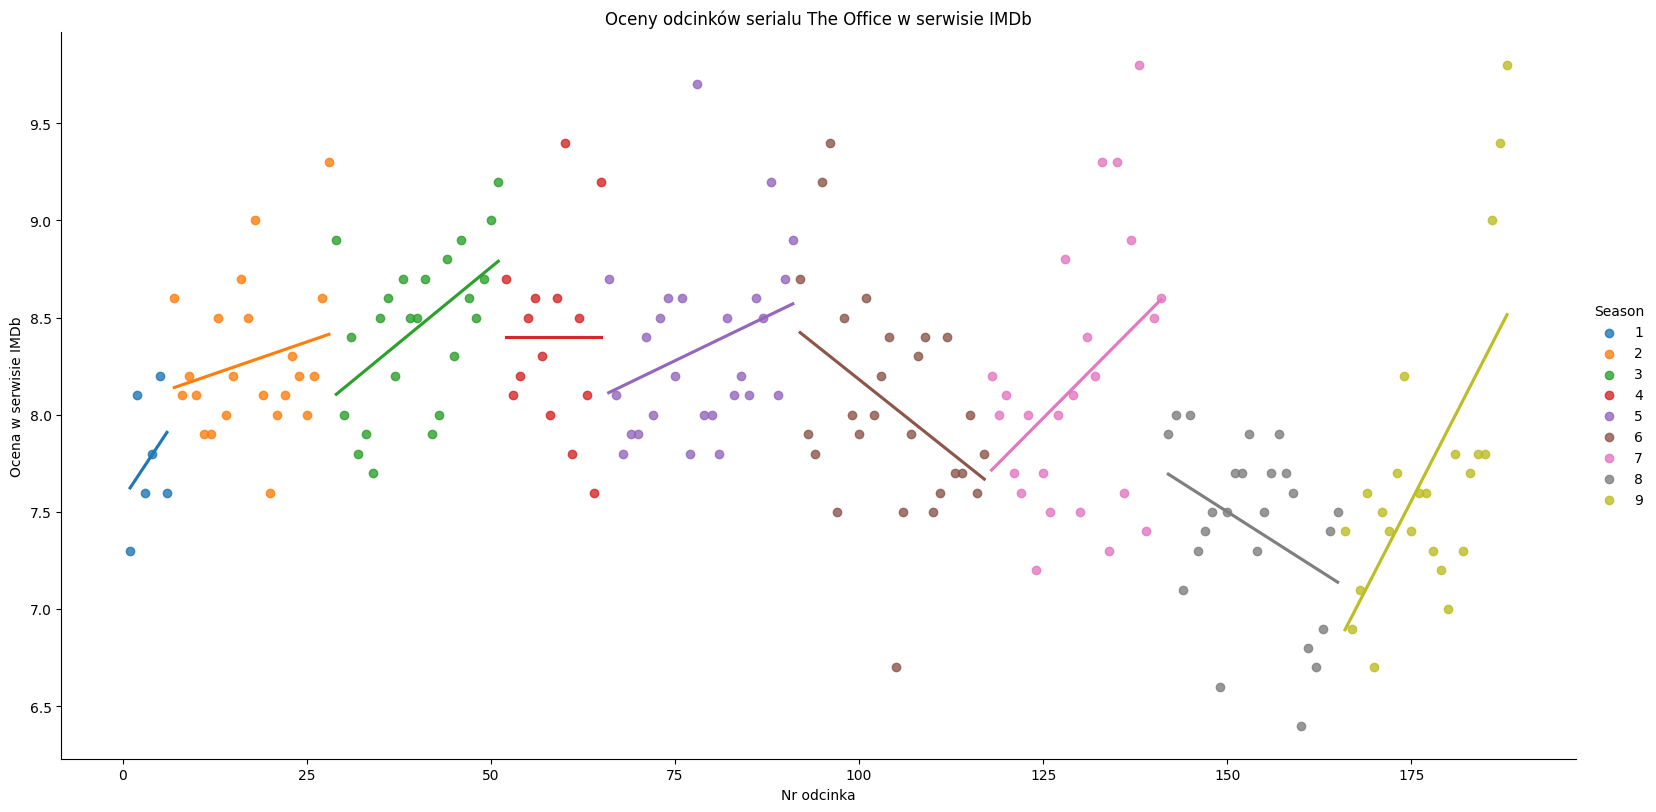

In [ ]:
#Utworzenie wykresu punktowego dla ocen odcinków
sns.lmplot(x="Episode No. (Overall)", y="Rating", hue="Season", data=the_office, height=8, aspect=2, ci=None)
plt.xlabel("Nr odcinka")
plt.ylabel("Ocena w serwisie IMDb")
plt.title("Oceny odcinków serialu The Office w serwisie IMDb");

Linie proste na wykresie wskazują ogólny trend w ocenach odcinków - rosnący lub malejący.
Na pierwszy rzut oka można stwierdzić, że aż do 7 sezonu włącznie oceny odcinków były dość stabilne, natomiast odcinki sezonu 8 i 9 są oceniane nieco niżej - chociaż w przypadku sezonu 9 obserwowany jest nagły skok ocen w przypadku 3 ostatnich odcinków.

## Analiza zmian w oglądalności serialu

Następnie przeszłam do analizy tego, jak zmieniała się oglądalność serialu w czasie.
Rozpoczęłam od obliczenia średniej oglądalności każdego sezonu.

In [ ]:
#Grupowanie danych po kolumnie "Season" i obliczenie średniej oglądalności na podstawie kolumny "Rating"
average_viewership = the_office.groupby('Season')['Viewership'].mean().round(2)

#Wyświetlenie średniej oglądalności dla każdego sezonu
for season in the_office['Season'].unique():
    average = average_viewership.loc[season]
    print(f"Sezon \033[1m{season}\033[0m: średnia oglądalność (w mln) = \033[1m{average}\033[0m")

Sezon 1: średnia oglądalność (w mln) = 6.37
Sezon 2: średnia oglądalność (w mln) = 8.17
Sezon 3: średnia oglądalność (w mln) = 8.49
Sezon 4: średnia oglądalność (w mln) = 8.55
Sezon 5: średnia oglądalność (w mln) = 8.76
Sezon 6: średnia oglądalność (w mln) = 7.77
Sezon 7: średnia oglądalność (w mln) = 7.31
Sezon 8: średnia oglądalność (w mln) = 5.39
Sezon 9: średnia oglądalność (w mln) = 4.14


Wyraźnie widać, że oglądalność znacząco spada w sezonie 8 i 9. Przedstawiłam to również na wykresach - najpierw na wykresie słupkowym  stworzonym za pomocą funkcji plt.bar z biblioteki Matplotlib.

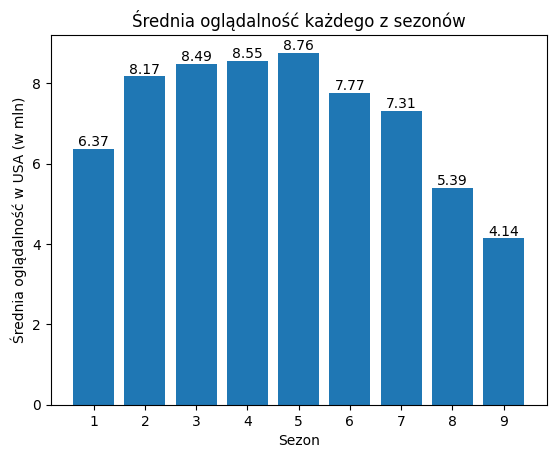

In [ ]:
#Przygotowanie danych do wykresu
seasons = the_office['Season'].unique()
average_values = average_viewership.values

#Tworzenie wykresu słupkowego
plt.bar(seasons, average_values)

#Dodanie tytułu wykresu oraz etykiet osi
plt.title("Średnia oglądalność każdego z sezonów")
plt.xlabel("Sezon")
plt.ylabel("Średnia oglądalność w USA (w mln)")

#Dostosowanie etykiet osi x
plt.xticks(seasons, seasons)

#Dodanie wartości do słupków
for i, value in enumerate(average_values):
    plt.text(seasons[i], value, str(value), ha='center', va='bottom')

#Wyświetlenie wykresu
plt.show()

Utworzyłam również wykres przedstawiający oglądalność poszczególnych odcinków w każdym z sezonów.

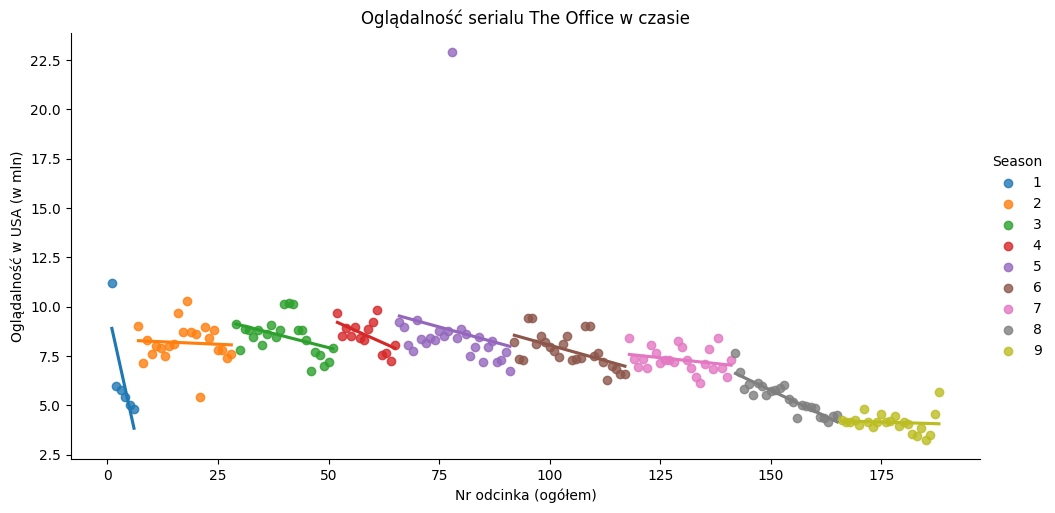

In [ ]:
sns.lmplot(x="Episode No. (Overall)", y="Viewership", hue="Season", data=the_office, height=5, aspect=2, ci=None)
plt.xlabel("Nr odcinka (ogółem)")
plt.ylabel("Oglądalność w USA (w mln)")
plt.title("Oglądalność serialu The Office w czasie");

Poza tym, że na wykresie widoczny jest wyraźny i postępujący spadek oglądalności w czasie, w sezonie 5 (kolor fioletowy) widoczna jest także wartość odstająca - wygląda ona dość podejrzanie, dlatego sprawdziłam, czy nie jest to przypadkiem błąd w danych.



In [ ]:
# Filtrowanie danych dla sezonu 5
season_5 = the_office[the_office['Season'] == 5]

# Znalezienie indeksu odcinka z największą oglądalnością
max_viewership_index = season_5['Viewership'].idxmax()

# Pobranie wartości kolumn "Title" i "Episode No." dla odcinka z największą oglądalnością
episode_title = season_5.loc[max_viewership_index, 'Title']
episode_number = season_5.loc[max_viewership_index, 'Episode No.']

# Wyświetlenie informacji o odcinku
print("Odcinek z największą oglądalnością w sezonie 5:")
print("Tytuł:", episode_title)
print("Numer odcinka:", episode_number)

Odcinek z największą oglądalnością w sezonie 5:
Tytuł: Stress Relief
Numer odcinka: 13


Mimo tego, że wydaje się wręcz niewiarygodne, żeby jeden z odcinków tak istotnie wybijał się na tle innych pod względem oglądalności i jednocześnie nie był odcinkiem finałowym, nie jest to błąd w danych - wg informacji ze strony IMDb: "Ze względu na to, że odcinek "Stress Relief" został wyemitowany po Super Bowl, przyciągnął on do ekranów ponad 20 milionów widzów, co czyni go najczęściej oglądanym odcinkiem całego serialu".
Odcinek pierwotnie został wyemitowany na antenie NBC w Stanach Zjednoczonych 1 lutego 2009 roku, bezpośrednio po zakończeniu transmisji Super Bowl XLIII. Decyzję o emisji odcinka właśnie po tym wydarzeniu podjęto ze względu na pozytywne opinie, jakie serial otrzymał po krótkich spotach reklamowych emitowanych podczas Letnich Igrzysk Olimpijskich w 2008 roku.
Lieberstein (jeden ze scenarzystów tego odcinka) przyznał, że podczas tworzenia scenariusza odcinka starał się przyciągnąć nowych widzów i zachęcić ich do regularnego oglądania serialu, ale jednocześnie nie wykluczyć wiernych fanów. Scenariusz celowo nie skupiał się więc na trwających od kilku sezonów wątkach fabularnych nieznanych nowym widzom. W zasadzie napisano więc nowy odcinek "Pilot".

Oceniłam również, czy obecność Steve'a Carella rzeczywiście miała wpływ na oglądalność serialu.

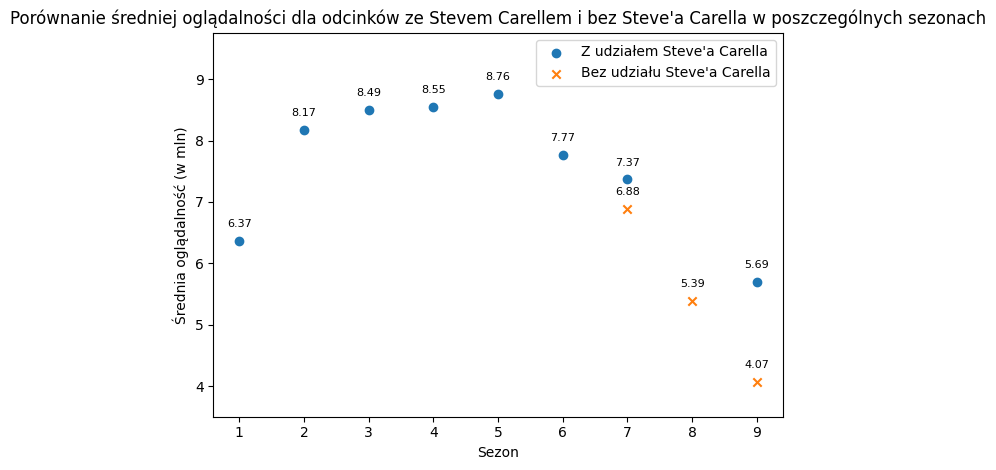

In [ ]:
#Grupowanie danych po sezonach i obliczenie średniej oglądalności dla odcinków ze Stevem Carellem i bez Steve'a Carella
average_viewership_with_carell = the_office.loc[the_office['Michael Scott (Steve Carell)'] == True].groupby('Season')['Viewership'].mean()
average_viewership_without_carell = the_office.loc[the_office['Michael Scott (Steve Carell)'] == False].groupby('Season')['Viewership'].mean()

#Ustawienie zakresu osi y
plt.ylim(3.5, max(max(average_viewership_with_carell), max(average_viewership_without_carell)) + 1)

#Generowanie wykresu punktowego
plt.scatter(average_viewership_with_carell.index, average_viewership_with_carell, marker='o',
            label='Z udziałem Steve\'a Carella')
plt.scatter(average_viewership_without_carell.index, average_viewership_without_carell, marker='x',
            label='Bez udziału Steve\'a Carella')
plt.xlabel('Sezon')
plt.ylabel('Średnia oglądalność (w mln)')
plt.title('Porównanie średniej oglądalności dla odcinków ze Stevem Carellem i bez Steve\'a Carella w poszczególnych sezonach')


#Wyświetlanie wartości przy kropkach
for i, viewership in enumerate(average_viewership_with_carell):
    plt.annotate(round(viewership, 2), (average_viewership_with_carell.index[i],
                                        viewership), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

#Wyświetlanie wartości przy krzyżykach
for i, viewership in enumerate(average_viewership_without_carell):
    plt.annotate(round(viewership, 2), (average_viewership_without_carell.index[i],
                                        viewership), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.tight_layout()
plt.legend()
plt.show()

Na wykresie punktowym wyraźnie widać spadek oglądalności w przypadku odcinków bez Steve'a Carella. W ostatnim sezonie pojawia się on jedynie w ostatnim odcinku (i w zasadzie mówi jedynie kilka słów), a jednak oglądalność tego odcinka jest znacznie wyższa - choć oczywiscie może na to również wpływać fakt, że jest to odcinek finalowy, kończący cały serial.

## Analiza opisów odcinków

W ostatniej części analizy tego zestawu danych pod lupę wzięłam opisy odcinków.

Do tej części analizy potrzebne były dodatkowe zasoby z biblioteki nltk (Natural Language Toolkit):

*   word_tokenize - służy do tokenizacji, czyli podziału tekstu na pojedyncze słowa (tokeny).
*   stopwords - definiuje słowa "stopu" w różnych językach. Stop words to słowa, które występują w zdaniach z bardzo dużą częstotliwością, ale niosą ze sobą niewielką wartość - w języku angielskim są to np. słowa "a", "an", "the", "is", "in" itp. Funkcja stopwords umożliwia pobranie listy słów stopwords dla danego języka i usunięcie ich z analizowanych treści.
*   FreqDist - pozwala na obliczenie częstości występowania poszczególnych słów w danym zbiorze danych.

Dodatkowo wykorzystałam moduł re jest częścią standardowej biblioteki Pythona i odnosi się do modułu wyrażeń regularnych (Regular Expressions).


Przed przystąpieniem do analizy tekstu wymagane jest odpowiednie przygotowanie danych. Obejmuje ono zamianę wielkich liter na male litery, usunięcie wszystkich znaków interpunkcyjnych i znaków specjalnych, tokenizację słów, usunięcie słów stopwords i lematyzację słów.

In [ ]:
#Przygotowanie danych
description_list=[]
for description in the_office.About:
    description=re.sub("[^a-zA-Z]", " ", description)  ###usunięcie znaków interpunkcyjnych i znaków specjalnych
    description=description.lower() ###zastąpienie wielkich liter małymi literami
    description=nltk.word_tokenize(description) ###'tokenizacja' słów (podział na pojedyncze słowa)
    description=[word for word in description if not word in set(stopwords.words("english"))]  ###usunięcie stopwords
    lemma=nltk.WordNetLemmatizer()
    description=[lemma.lemmatize(word) for word in description] ###lematyzacja słów
    description=" ".join(description)
    description_list.append(description)

In [ ]:
#Stworzenie kolumny "new_about" z danymi przygotowanymi do analizy
the_office["new_about"]=description_list
the_office.head()

,Season,Episode No.,Episode No. (Overall),Title,Airdate,Rating,Votes,Viewership,Duration,Michael Scott (Steve Carell),About,new_about
0,1,1,1,Pilot,2005-03-24,7.3,9283,11.2,23,True,The premiere episode introduces the boss and s...,premiere episode introduces bos staff dunder m...
1,1,2,2,Diversity Day,2005-03-16,8.1,9169,6.0,23,True,Michael's off color remark puts a sensitivity ...,michael color remark put sensitivity trainer o...
2,1,3,3,Health Care,2005-04-05,7.6,7611,5.8,22,True,Michael leaves Dwight in charge of picking the...,michael leaf dwight charge picking new healthc...
3,1,4,4,The Alliance,2005-04-12,7.8,7344,5.4,23,True,"Just for a laugh, Jim agrees to an alliance wi...",laugh jim agrees alliance dwight regarding dow...
4,1,5,5,Basketball,2005-04-19,8.2,8154,5.0,23,True,Michael and his staff challenge the warehouse ...,michael staff challenge warehouse worker baske...


In [ ]:
# Tworzenie obiektu FreqDist na podstawie zawartości kolumny "new_about"
freq_dist = FreqDist(' '.join(the_office['new_about']).split())

# Wyświetlanie 10 najczęściej występujących słów wraz z ich liczebnością
most_common_words = freq_dist.most_common(10)
for word, frequency in most_common_words:
    print(word, ":", frequency)

michael : 155
dwight : 101
jim : 92
office : 82
pam : 75
andy : 70
try : 55
dunder : 45
mifflin : 45
meanwhile : 45


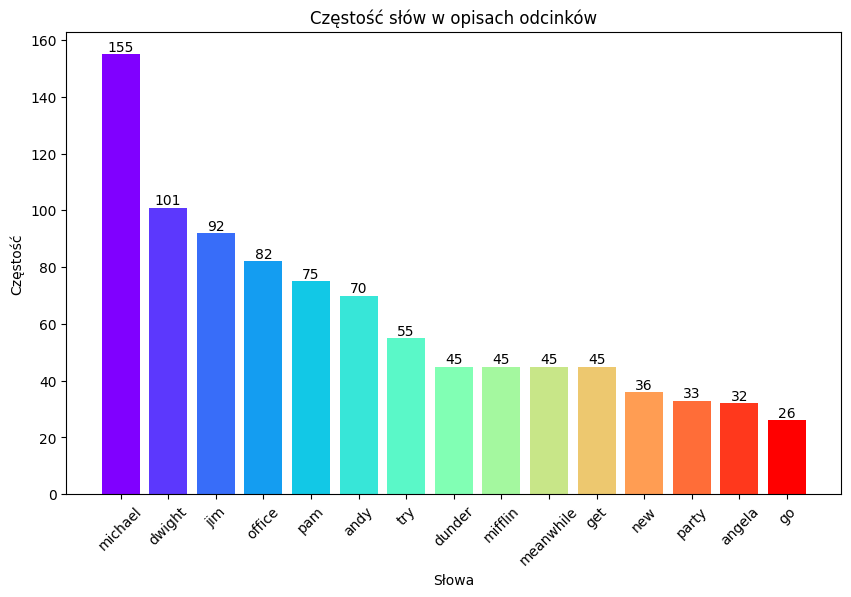

In [ ]:
#Przedstawienie uzyskanych wyników dotyczących częstości słow na wykresie
labels = [word for word, _ in freq_dist.most_common(15)]  #Wybranie 15 słów, które występują najczęściej w opisach odcinków
counts = [count for _, count in freq_dist.most_common(15)]  #Określenie częstości występowania wybranych słów

rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))  #Wybór "tęczowych" kolorów dla wykresu

#Utworzenie wykresu słupkowego
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=rainbow_colors)

plt.title('Częstość słów w opisach odcinków')
plt.xlabel('Słowa')
plt.ylabel('Częstość')

#Dodanie etykiet dla każdego słupka
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, counts[i], ha='center', va='bottom')


plt.xticks(rotation=45)  #Obrócenie etykiet słów o 45 stopni w celu zapewnienia lepszej czytelności

plt.show()

Słowem, które najczęściej występuje w opisach odcinków, jest słowo Michael - zdecydowanie deklasuje ono pozostałe słowa, pomimo tego, że postać Michaela nie występuje w aż 49 odcinkach serialu! Kolejne najczęściej występujące słowa to Dwight, Jim, office, Pam oraz Andy. Często pojawia się również nazwa firmy, w której pracują bohaterowie - Dunder Mifflin.

Stworzyłam również chmurkę słów najczęściej występujących słów w opisach odcinków:

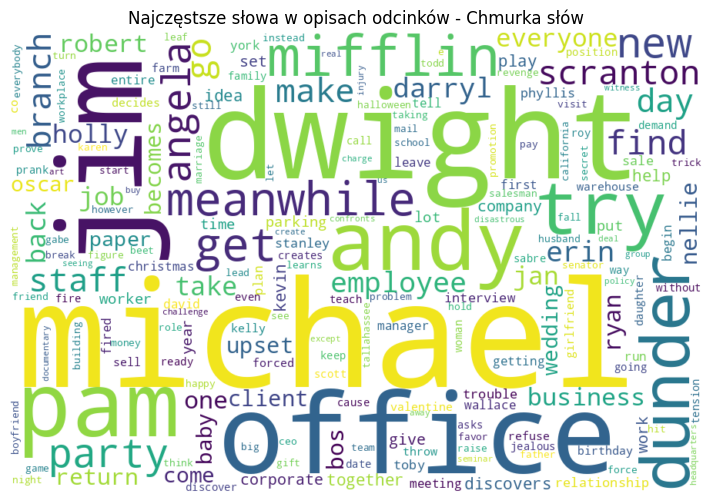

In [ ]:
#Utworzenie chmurki słów na podstawie obliczonych wczesniej częstości
wordcloud = WordCloud(width=900, height=600, background_color='white', colormap='viridis').generate_from_frequencies(freq_dist)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Najczęstsze słowa w opisach odcinków - Chmurka słów')
plt.show()

# Trzeci zestaw danych

Analiza słów spodobała mi się na tyle, że postanowiłam pójść o krok dalej. Udało mi się znaleźć zestaw danych zawierający wszystkie dialogi wypowiadane w serialu The Office, wraz z podziałem ich na odpowiednie postacie. Dane pobrałam ze strony https://data.world/abhinavr8/the-office-scripts-dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
dialogues = pd.read_csv("The_Office_lines.csv")
dialogues.head(3)

,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False


In [ ]:
dialogues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59909 entries, 0 to 59908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         59909 non-null  int64 
 1   season     59909 non-null  int64 
 2   episode    59909 non-null  int64 
 3   scene      59909 non-null  int64 
 4   line_text  59909 non-null  object
 5   speaker    59909 non-null  object
 6   deleted    59909 non-null  bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 2.8+ MB


Ramka danych "dialogues" zawiera informacje pobrane ze scenariusza serialu "The Office". Składa się ona z następujących kolumn:

    "id": identyfikator każdej kwestii wypowiadanej przez postacie.
    "season": numer sezonu, w którym wypowiedziano daną kwestię.
    "episode": numer odcinka.
    "scene": numer sceny.
    "line_text": kwestia wypowiadana przez postać.
    "speaker": imię postaci, która wypowiada daną kwestię.
    "deleted": informacja  True/False wskazująca, czy dana kwestia została usunięta z ostatecznej wersji scenariusza.

Nie odnotowano braków danych. Postanowiłam sprawdzić, ile kwestii zostało usuniętych z ostatecznej wersji scenariusza.

In [ ]:
deleted_lines = dialogues['deleted'].value_counts()
deleted_lines

False    57973
True      1936
Name: deleted, dtype: int64

In [ ]:
deleted_counts_per_season = dialogues.groupby(['season', 'deleted']).size().unstack()
deleted_counts_per_season

deleted,False,True
season,,
1,1536.0,460.0
2,6051.0,1441.0
3,7448.0,35.0
4,5642.0,NaN
5,8170.0,NaN
6,7630.0,NaN
7,7302.0,NaN
8,7083.0,NaN
9,7111.0,NaN


Jak widać z pierwotnej wersji scenariusza nie usunięto dużej liczby kwestii - zaledwie ok. 2 tys. względem ok. 58 tys. kwestii, które wybrzmiały w telewizji, przy czym większość usuniętych kwestii pochodzi z 2. sezonu.

## Czyszczenie danych

Z racji tego, że jest to duży zbiór danych tekstowych, przed przystąpieniem do analizy konieczne było oczyszczenie danych.
Czyszczenie danych obejmowało:
  - usunięcie didaskaliów zamieszczonych w nawiasach kwadratowych np. [Phone ringing]
  - usunięcie spacji, które mogą znajdować się na końcach wierszy
  - wyeliminowanie błędów w zapisach imion poszczególnych postaci, które mogą prowadzić do identyfikacji jednej postaci różnymi imionami
  - zastąpienie wielkich liter małymi literami

In [ ]:
#Usunięcie przypisów w nawiasach kwadratowych np. [Laughing] oraz spacji z końca wierszy + zamiana wielkich liter na małe litery
#w kolumnach z nazwami postaci i wypowiadanymi przez nie kwestiami

dialogues['speaker'] = dialogues['speaker'].str.replace(r'\[.*?\]', '').str.strip().str.lower()
dialogues['line_text'] = dialogues['line_text'].str.replace(r'\[.*?\]', '').str.strip().str.lower()

In [ ]:
#Wyświetlenie liczby niepowtarzalnych postaci
unique_speakers = dialogues['speaker'].nunique()
unique_speakers

755

Jak widać w serialu pojawia się bardzo wiele postaci. Analiza nie będzie się jednak koncentrować na nich wszystkich - najbardziej interesują mnie najpopularniejsze postacie w serialu. Wyodrębniłam więc 10 postaci, które wypowiadają najwięcej kwestii.

In [ ]:
dialogues['speaker'].value_counts().head(10)

michael    12151
dwight      7535
jim         6817
pam         5380
andy        3969
kevin       1709
angela      1695
oscar       1491
erin        1469
ryan        1379
Name: speaker, dtype: int64

5 najważnieszych postaci w serialu "The Office" (w kolejności malejącej liczby kwestii) to Michael, Dwight, Jim, Pam, Andy.
To, jak bardzo pozostałe postacie "odstają" od tych bohaterów, doskonale widać na wykresie słupkowym:

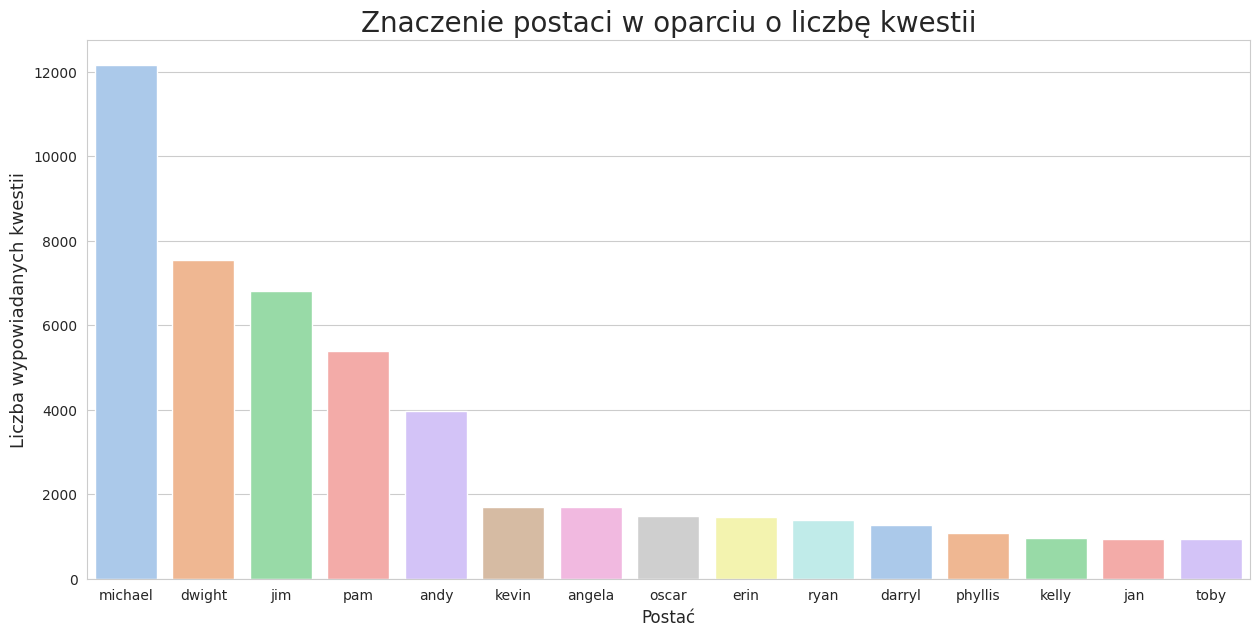

In [ ]:
#Wykres przedstawiający liczbę kwestii wypowiadanych przez poszczególne postaci (15 postaci z największą liczbą kwestii)
sns.set_style('whitegrid')
plt.figure(figsize=(15,7))
sns.countplot(x='speaker', data=dialogues, order=dialogues.speaker.value_counts().iloc[:15].index, palette="pastel")
plt.xlabel('Postać', fontsize=12)
plt.ylabel('Liczba wypowiadanych kwestii', fontsize=13)
plt.title('Znaczenie postaci w oparciu o liczbę kwestii', fontsize=20)
plt.show()

Jak można się było spodziewać "najwięcej do powiedzenia" w serialu miał Michael Scott. Jego imię, oraz imię Dwight, są jednak dość problematyczne w zapisie w porównaniu do pozostałych (Jim/Pam/Andy) i łatwo zrobić w nich literówkę - sprawdziłam więc, czy błędy w zapisie tych imion nie są obecne w tym zestawie danych.

In [ ]:
#Wybranie wierszy z ramki, które zawierają sekwencję znaków 'mic' lub 'ael' i wyświetlenie niepowtarzalnych wartości
michael_variants = dialogues[dialogues['speaker'].str.contains('mic|ael')]
michael_variants['speaker'].unique()

array(['michael', 'michael and dwight', 'dwight and michael',
       'michael and christian', 'michael and jim',
       'phyllis, meredith, michael, kevin', 'young michael', 'm ichael',
       'michael & dwight', 'andy & michael', 'andy and michael',
       "michael's ad", 'michae', 'michael/dwight', 'michael and darryl',
       'woman on mic', 'micheal', 'michael & holly', 'michael and holly',
       'michael, holly, and darryl', 'holly & michael', 'michel',
       'warehouse michael', 'jim, pam, michael and dwight', 'michal',
       'michael, pam & ryan', 'michael and erin',
       'dwight, jim and michael', 'miichael', 'michael and donna',
       'mihael', 'michael and andy', 'ryan and michael', 'video michael',
       'deangelo/michael'], dtype=object)

In [ ]:
#Wyświetlenie tylko tych 'imion', które nie zawierają słowa 'michael'
michael_variants_filtered = michael_variants[~michael_variants['speaker'].str.contains('michael')]
michael_variants_filtered['speaker'].value_counts()

micheal         8
michel          4
m ichael        1
michae          1
woman on mic    1
michal          1
miichael        1
mihael          1
Name: speaker, dtype: int64

Zidentyfikowałam aż 7 nieprawidłowych wersji imienia Michael - micheal, michel, m ichael, michae, michal, miichael, mihael - i zastąpiłam je prawidłowym zapisem:

In [ ]:
#Zastąpienie wszystkich nieprawidłowych zapisów słowem michael
invalid_variants = ['micheal', 'michel', 'm ichael', 'michae', 'michal', 'miichael', 'mihael']
dialogues['speaker'] = dialogues['speaker'].str.replace(r'\b(?:' + '|'.join(invalid_variants) + r')\b', 'michael')

In [ ]:
#Kontrola, czy wszystkie słowa z literówkami zostały zastąpione [powinna zostać tylko "kobieta przy mikrofonie"]
michael_variants = dialogues[dialogues['speaker'].str.contains('mic|ael')]
michael_variants_filtered = michael_variants[~michael_variants['speaker'].str.contains('michael')]
michael_variants_filtered

,id,season,episode,scene,line_text,speaker,deleted
21898,21899,4,13,37,the job fair will be closing in five minutes. ...,woman on mic,False


In [ ]:
dialogues['speaker'].value_counts().head(1)

michael    12168
Name: speaker, dtype: int64

Przed zastąpieniem słów z literówkami łączna liczba kwestii wypowiadanych przez Michaela wynosiła 12151, a po wprowadzeniu zmian 12168 - błędów w zapisie nie było więc szczególnie dużo w stosunku do ogólnej liczby danych i raczej nie wpłynęłoby to na analizę, jednak przy mniejszych zestawach danych takie literówki mogłyby mieć duże znaczenie.

Sprawdziłam również, czy problem taki nie wystepuje w przypadku imienia Dwight.

In [ ]:
dwight_variants = dialogues[dialogues['speaker'].str.contains('dwi|ght|ight')]
print(dwight_variants['speaker'].unique())
dwight_variants_filtered = dwight_variants[~dwight_variants['speaker'].str.contains('dwight')]
dwight_variants_filtered

['dwight' 'michael and dwight' 'dwight and michael' 'dwight and roy'
 'jim and dwight' 'jim, josh, and dwight' 'michael & dwight'
 'dwightkschrute' 'michael/dwight' 'angela and dwight'
 'prince granddaughter' 'jim, pam, michael and dwight' 'dwight and erin'
 'dwight and andy' 'dwight & andy' 'dwight, jim & pam' 'andy and dwight'
 'dwight, jim and michael' 'night cleaning crew' 'dwight and angela'
 'employees except dwight' 'dwight & nate' 'phyllis, stanley, dwight'
 'dwight, erin, jim & kevin' 'pam & dwight' 'jim & dwight']


,id,season,episode,scene,line_text,speaker,deleted
26543,26544,5,12,13,"grandma, i can't do this.",prince granddaughter,False
26545,26546,5,12,13,right.,prince granddaughter,False
26547,26548,5,12,13,8,prince granddaughter,False
26599,26600,5,12,20,its all better.,prince granddaughter,False
36260,36261,6,17,37,"oh! sorry! sorry, sorry.",night cleaning crew,False


Nie zidentyfikowałam żadnych literówek w imieniu "dwight". Imiona Jim, Pam i Andy są na tyle krótkie, że raczej nie jest możliwe popełnienie w nich błędów.

Zastąpiłam również znak "&" pojawiający się w kolumnie 'speakers' słowem 'and', gdyż zauważyłam, że są one używane zamiennie.

In [ ]:
dialogues['speaker'] = dialogues['speaker'].str.replace('&', 'and')

# Analiza danych

## Analiza zestawu danych pod kątem liczby kwestii oraz liczby słów

Analizę rozpoczęłam od identyfikacji 5 postaci, które wypowiedziały najwięcej kwestii w każdym z sezonów.

In [ ]:
# Obliczanie liczby kwestii dla każdej postaci w każdym sezonie
speaker_lines_per_season = dialogues.groupby(['season', 'speaker']).size().rename('liczba_kwestii').reset_index()

# Obliczanie liczby kwestii dla każdego sezonu
total_lines_per_season = speaker_lines_per_season.groupby('season')['liczba_kwestii'].sum()

#Zidentyfikowanie 5 postaci z każdego sezonu, które miały najwięcej kwestii
top_5_speakers_per_season = (
    speaker_lines_per_season
    .sort_values(['season', 'liczba_kwestii'], ascending=[True, False])
    .groupby('season')
    .head(5)
    .set_index(['season', 'speaker'])
)
top_5_speakers_per_season.head()

liczba_kwestii
season speaker                
1      michael             643
       dwight              326
       jim                 285
       pam                 219
       katy                 73

In [ ]:
# Obliczanie udziału procentowego kwestii wypowiadanych przez 5 wybranych postaci we wszystkich kwestiach
top_5_speakers_per_season['udzial_procentowy'] = (
    top_5_speakers_per_season.groupby('season')['liczba_kwestii']
    .apply(lambda x: (x / total_lines_per_season[x.name] * 100).round(decimals=2))
)

# Wyświetlanie zaktualizowanej ramki danych
top_5_speakers_per_season

liczba_kwestii  udzial_procentowy
season speaker                                   
1      michael             643              32.21
       dwight              326              16.33
       jim                 285              14.28
       pam                 219              10.97
       katy                 73               3.66
2      michael            2324              31.02
       dwight             1114              14.87
       jim                 906              12.09
       pam                 729               9.73
       jan                 285               3.80
3      michael            1993              26.63
       dwight              941              12.58
       jim                 783              10.46
       pam                 665               8.89
       andy                391               5.23
4      michael            1637              29.01
       jim                 684              12.12
       dwight              547               9.70
       pam                 528               9.36
       ryan                228               4.04
5      michael            2173              26.60
       dwight             1076              13.17
       jim                 877              10.73
       pam                 710               8.69
       andy                497               6.08
6      michael            1989              26.07
       jim                 928              12.16
       dwight              812              10.64
       pam                 706               9.25
       andy                538               7.05
7      michael            1407              19.27
       dwight              704               9.64
       jim                 687               9.41
       pam                 613               8.39
       andy                557               7.63
8      andy               1125              15.88
       dwight              946              13.36
       jim                 869              12.27
       pam                 475               6.71
       erin                427               6.03
9      dwight             1069              15.03
       jim                 798              11.22
       pam                 735              10.34
       andy                638               8.97
       angela              381               5.36

Dzięki tej ramce danych łatwo można stwierdzić, że aż do sezonu 7 Michael grany przez Steve'a Carella miał największy udział procentowy w liczbie kwestii wypowadanych przez wszystkie postacie - nierzadko odsetek ten przekraczał 25%. Na drugim i trzecim miejscu zwykle plasował się Jim i Dwight (w różnej kolejności). W sezonie 8 najwięcej kwestii ma Andy, a w sezonie 9 Dwight.

Obliczyłam również łączną liczbę słów wypowiadaną przez każdą z postaci i przedstawiłam uzyskane wyniki na wykresie.

In [ ]:
#Dodanie nowej kolumny zawierającej liczbę słów w każdej kwestii
dialogues['dialogue_wordcount'] = dialogues['line_text'].map(lambda x:len(re.findall(r'\w+', x)))
dialogues.head(3)

,id,season,episode,scene,line_text,speaker,deleted,dialogue_wordcount
0,1,1,1,1,all right jim. your quarterlies look very good...,michael,False,14
1,2,1,1,1,"oh, i told you. i couldn't close it. so...",jim,False,10
2,3,1,1,1,so you've come to the master for guidance? is ...,michael,False,16


In [ ]:
#Obliczenie łącznej liczby słów wypowiadanych przez każdą z postaci
total_char_words = dialogues.groupby('speaker', as_index=False).dialogue_wordcount.sum()
total_char_words = total_char_words.sort_values('dialogue_wordcount', ascending=False)
total_char_words.head(3)

,speaker,dialogue_wordcount
431,michael,176306
204,dwight,88152
332,jim,66206


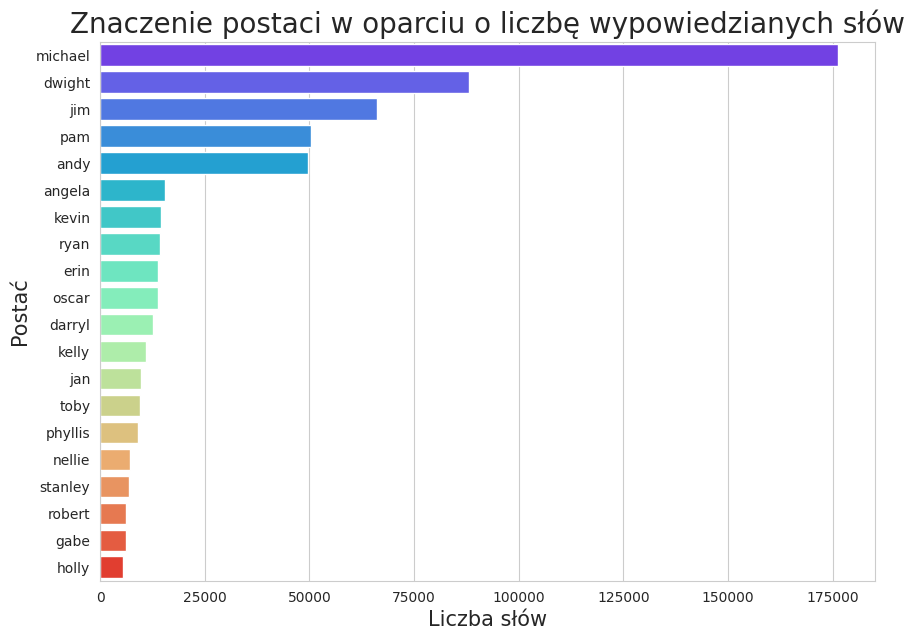

In [ ]:
#Przedstawienie uzyskanych danych na wykresie (dla 20 postaci, które wypowiedziały najwiecej słów)
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x='dialogue_wordcount', y='speaker', data=total_char_words, palette="rainbow", order=total_char_words.sort_values('dialogue_wordcount', ascending=False).speaker[0:20], orient='h')
plt.xlabel('Liczba słów', fontsize=15)
plt.ylabel('Postać', fontsize=15)
plt.title('Znaczenie postaci w oparciu o liczbę wypowiedzianych słów', fontsize=20);

Uzyskane dane pokrywają się z wykresem, na którym przedstawiono analizę znaczenia postaci w oparciu o liczbę wypowiadanych przez nie kwestii - do pierwszej piątki dalej należy Michael, Dwight, Jim, Pam i Andy.

## Analiza słów w scenariuszu serialu

Następnie przeszłam do analizy słów najczęściej występujących w serialu. W tym celu konieczne było odpowiednie przygotowanie kwestii wypowiadanych przez postacie - w podobny sposób jak opisów odcinków.
Ponadto wykluczyłam słowa, które zawierały mniej niż 3 znaki.

In [ ]:
dialogues_list = []
for line in dialogues.line_text:
    line = re.sub("[^a-zA-Z]", " ", line)
    line = nltk.word_tokenize(line)
    line = [word for word in line if len(word) > 2 and not word in set(stopwords.words("english"))]
    lemma = nltk.WordNetLemmatizer()
    line = [lemma.lemmatize(word) for word in line]
    line = " ".join(line)
    dialogues_list.append(line)

In [ ]:
dialogues['line_text_processed'] = dialogues_list
dialogues.head()

,id,season,episode,scene,line_text,speaker,deleted,dialogue_wordcount,line_text_processed
0,1,1,1,1,all right jim. your quarterlies look very good...,michael,False,14,right jim quarterly look good thing library
1,2,1,1,1,"oh, i told you. i couldn't close it. so...",jim,False,10,told close
2,3,1,1,1,so you've come to the master for guidance? is ...,michael,False,16,come master guidance saying grasshopper
3,4,1,1,1,"actually, you called me in here, but yeah.",jim,False,8,actually called yeah
4,5,1,1,1,"all right. well, let me show you how it's done.",michael,False,11,right well let show done


In [ ]:
# Utworzenie listy pojedynczych słów
filtered_words = [word for word in ' '.join(dialogues['line_text_processed']).split()]

#Uworzenie obiektu FreqDist na podstawie odfiltrowanych słów
freq_distance = FreqDist(filtered_words)

# Wyświetlenie 20 najczęściej występujących słów wraz z ich liczebnością
most_frequent_words = freq_distance.most_common(20)
for word, frequency in most_frequent_words:
    print(word, ":", frequency)

know : 4557
like : 3410
yeah : 3223
okay : 2974
get : 2750
right : 2695
well : 2507
hey : 2422
think : 2350
good : 2233
one : 2176
michael : 2135
want : 2063
really : 2026
going : 1982
yes : 1722
would : 1716
got : 1704
guy : 1619
let : 1601


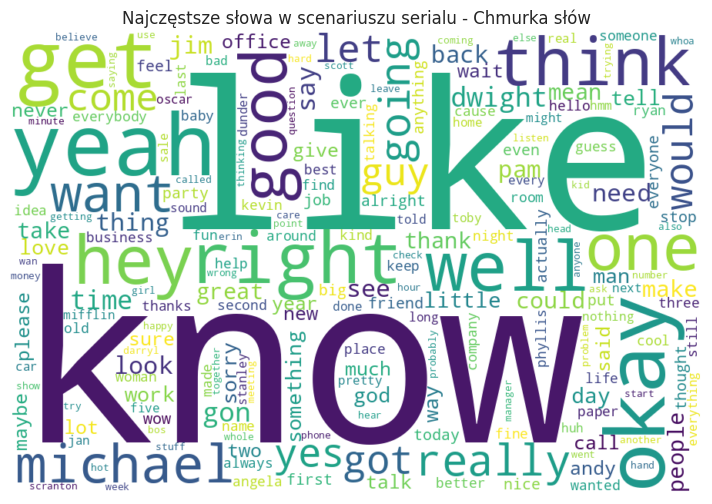

In [ ]:
#Chmurka słów
wordcloud = WordCloud(width=900, height=600, background_color='white', colormap='viridis').generate_from_frequencies(freq_distance)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Najczęstsze słowa w scenariuszu serialu - Chmurka słów')
plt.show()

Postanowiłam także sprawdzić, jakie pary słów najczęściej pojawiają się w kwestiach wypowiadanych przez postacie - w tym celu wykorzystałam funkcję bigrams z biblioteki NLTK.

In [ ]:
# Tworzenie bigramów na podstawie zawartości kolumny "line_text_processed"
text = ' '.join(dialogues['line_text_processed'])
text_bigrams1 = list(bigrams(text.split()))

# Tworzenie obiektu FreqDist na podstawie bigramów
freq_distance_bigrams1 = FreqDist(text_bigrams1)

# Wyświetlanie 20 najczęściej występujących par słów wraz z ich liczebnością
most_common_bigrams1 = freq_distance_bigrams1.most_common(20)
for bigram, frequency in most_common_bigrams1:
    print(bigram, ":", frequency)

('hey', 'hey') : 332
('dunder', 'mifflin') : 320
('would', 'like') : 249
('michael', 'scott') : 211
('yeah', 'yeah') : 206
('okay', 'okay') : 200
('look', 'like') : 181
('know', 'know') : 179
('let', 'get') : 161
('feel', 'like') : 157
('yes', 'yes') : 155
('little', 'bit') : 155
('right', 'right') : 131
('get', 'back') : 123
('new', 'york') : 122
('yeah', 'know') : 119
('good', 'good') : 116
('well', 'know') : 113
('dwight', 'schrute') : 111
('whoa', 'whoa') : 111


Nie ma tutaj wielkiego zaskoczenia - jedna z najczęściej występujących par słów to nazwa firmy, w której toczy się akcja serialu - Dunder Mifflin. Pojawiają się także dwa imiona i nazwiska postaci - Michael Scott i Dwight Shrute. Sprawdziłam jeszcze, jak prezentują się wyniki po wykluczeniu bigramów, które składają się z dwóch identycznych słów (np. "yes yes"), i przedstawiłam je na wykresie.

In [ ]:
# Utworzenie bigramów na podstawie zawartości kolumny "line_text_processed"
text = ' '.join(dialogues['line_text_processed'])
text_bigrams2 = list(bigrams(text.split()))

# Utworzenie obiektu FreqDist na podstawie bigramów (z wykluczeniem powtórzeń)
freq_distance_bigrams2 = FreqDist(bigram for bigram in text_bigrams2 if bigram[0] != bigram[1])

# Wyświetlanie 20 najczęściej występujących par słów wraz z ich liczebnością
most_common_bigrams2 = freq_distance_bigrams2.most_common(20)
for bigram, frequency in most_common_bigrams2:
    print(bigram, ":", frequency)

('dunder', 'mifflin') : 320
('would', 'like') : 249
('michael', 'scott') : 211
('look', 'like') : 181
('let', 'get') : 161
('feel', 'like') : 157
('little', 'bit') : 155
('get', 'back') : 123
('new', 'york') : 122
('yeah', 'know') : 119
('well', 'know') : 113
('dwight', 'schrute') : 111
('hey', 'guy') : 107
('yeah', 'well') : 103
('thank', 'much') : 101
('come', 'back') : 101
('okay', 'well') : 100
('conference', 'room') : 99
('okay', 'know') : 97
('let', 'see') : 94


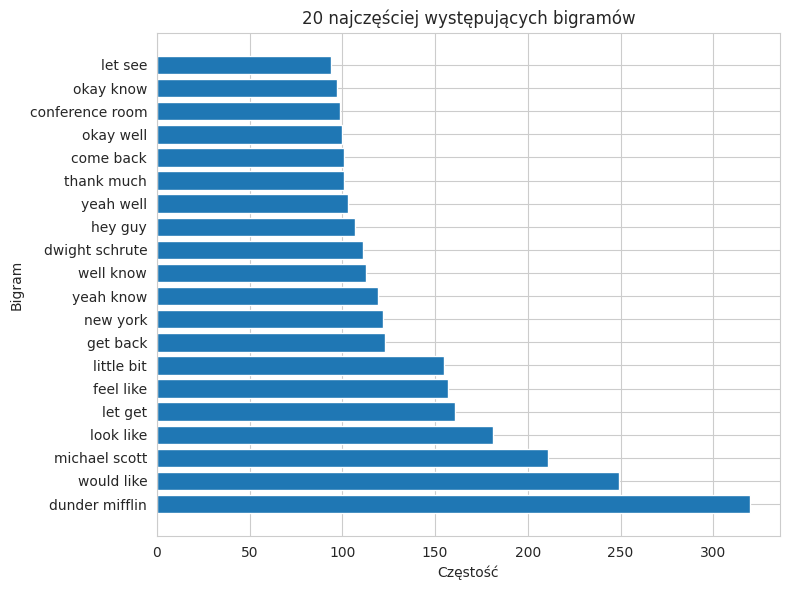

In [ ]:
# Pobieranie danych dla wykresu
bigrams2, frequencies2 = zip(*most_common_bigrams2)
bigrams2 = [' '.join(bigram) for bigram in bigrams2]  # Konwersja bigramów na stringi

# Tworzenie wykresu słupkowego
plt.figure(figsize=(8, 6))
plt.barh(bigrams2, frequencies2)
plt.xlabel('Częstość')
plt.ylabel('Bigram')
plt.title('20 najczęściej występujących bigramów')
plt.tight_layout()  # Dostosowanie odstępów między elementami wykresu
plt.show()

W prezentowanych wynikach nie pojawiły się żadne nowe postacie.
Sprawdziłam dodatkowo, jak wygląda kwestia trigramów. Do tego celu wykorzystałam funkcję ngrams.

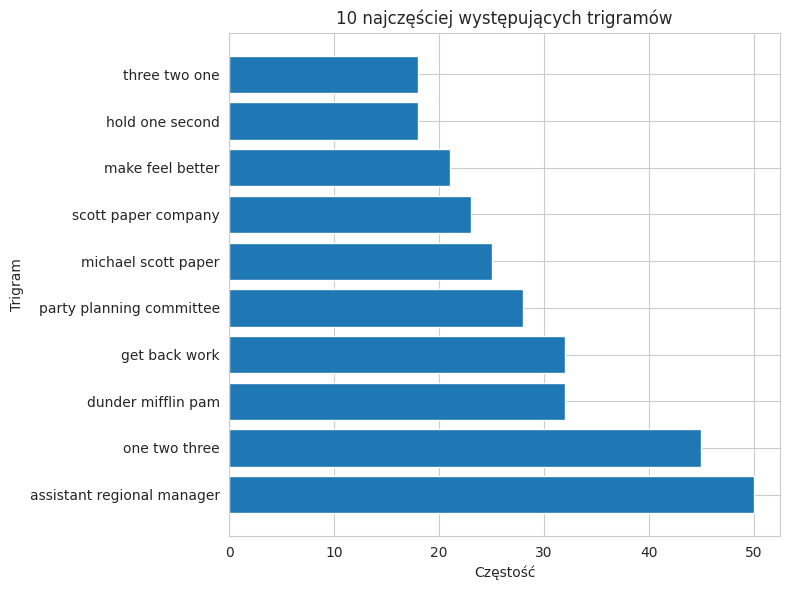

In [ ]:
# Tworzenie trigramów na podstawie zawartości kolumny "line_text_processed"
text = ' '.join(dialogues['line_text_processed'])
text_trigrams = list(ngrams(text.split(), 3))

# Tworzenie obiektu FreqDist na podstawie trigramów (z wykluczeniem powtórzeń)
freq_distance_trigrams = FreqDist(trigram for trigram in text_trigrams if len(set(trigram)) > 1)

# Wyświetlanie 10 najczęściej występujących trigramów wraz z ich liczebnością
most_common_trigrams = freq_distance_trigrams.most_common(10)

# Pobieranie danych dla wykresu
trigrams, frequencies = zip(*most_common_trigrams)
trigrams = [' '.join(trigram) for trigram in trigrams]  # Konwersja trigramów na stringi

# Tworzenie wykresu słupkowego
plt.figure(figsize=(8, 6))
plt.barh(trigrams, frequencies)
plt.xlabel('Częstość')
plt.ylabel('Trigram')
plt.title('10 najczęściej występujących trigramów')
plt.tight_layout()  # Dostosowanie odstępów między elementami wykresu
plt.show()


Chciałam również ocenić, ile razy w serialu padła słynna kwestia "That's what she said" i czy była ona wypowiadana wyłącznie przez Michaela. Kwestia ta stała się jednym z najbardziej rozpoznawalnych żartów związanych z serialem "The Office". Wiązana jest ona z postacią Michaela Scotta, który zasłynął z wypowiadania tego zwykle bardzo nieodpowiedniego w danej sytuacji zdania, wprawiając ludzi w konsternację i zakłopotanie.

In [ ]:
# Obliczenie liczby wystąpień sekwencji słów "That's what she said"
count = dialogues['line_text'].str.count("that's what she said").sum()

#Wyświetlenie wyniku
print("Liczba wystąpień sekwencji 'That's what she said':", count)

Liczba wystąpień sekwencji 'That's what she said': 40


In [ ]:
#Uzyskanie szczegółowych informacji o tym, kiedy padła kwestia "That's what she said" i kto ją wypowiedział
she_said = dialogues[dialogues['line_text'].str.contains("that's what she said")]
she_said = she_said[['speaker', 'season', 'episode']].sort_values(by='season').reset_index(drop=True)
she_said.head(3)

,speaker,season,episode
0,michael,2,2
1,jim,2,2
2,michael,2,2


In [ ]:
#Zidentyfikowanie postaci, które wypowiedziały daną kwestię
she_said["speaker"].value_counts()

michael                25
dwight                  3
jim                     2
everyone                1
jan                     1
stanley                 1
deposition reporter     1
pam                     1
david                   1
holly                   1
creed                   1
Name: speaker, dtype: int64

In [ ]:
#Zidentyfikowanie sezonów, w których padła kwestia
she_said["season"].value_counts()

4    10
2     8
3     8
5     5
7     4
9     2
6     1
Name: season, dtype: int64

Jak widać, chociaż to zdanie stało się charakterystycznym powiedzeniem dla postaci Michaela Scotta, nie był on jedynym bohaterem, który wypowiedział tę kwestię w toku serialu. Inni bohaterowie również czasami używali tej frazy, co zwykle powodowało głośny sprzeciw Michaela, który uznawał ją za "swój" żart. Powiedzenie to padło aż 10 razy w sezonie 4, natomiast nie pojawiło się w ogóle w sezonie 1, gdyż sezon ten w dużej mierze pokrywał się ze scenariuszem pierwowzoru, czyli brytyjskią wersją "The Office", oraz w sezonie 8, w którym nie było postaci Michaela.

Kolejnym z humorystycznych aspektów w serialu "The Office" była pewna niespójność dotycząca nazwy stanowiska przydzielonego Dwightowi przez Michaela Scotta. Dwight uparcie twierdził, że jego stanowisko to "Assistant Regional Manager", sugerując, że jest drugą osobą w hierarchii osób zarządzających. Jednak Michael, dyrektor, zawsze poprawiał go, używając tytułu "Assistant to the Regional Manager", aby podkreślić, że Dwight jest jedynie jego asystentem i nie ma pełnej władzy decyzyjnej.

Sprawdziłam zatem, ile razy w serialu pojawiły się kwestie odnoszące się do obu nazw tego jednego stanowiska.

In [ ]:
# Obliczenie liczby wystąpień sekwencji słów "Assistant to the regional manager"
count2 = dialogues['line_text'].str.count("assistant to the regional manager").sum()

#Wyświetlenie wyniku
print("Liczba kwestii z 'Assistant to the regional manager':", count2)

Liczba kwestii z 'Assistant to the regional manager': 19


In [ ]:
# Obliczenie liczby wystąpień sekwencji słów "Assistant regional manager"
count3 = dialogues['line_text'].str.count("assistant regional manager").sum()

#Wyświetlenie wyniku
print("Liczba kwestii z 'Assistant regional manager':", count3)

Liczba kwestii z 'Assistant regional manager': 29


Jak widać kwestii z "Assistant regional manager" jest o 10 więcej - może więc jednak Dwight nie był jedynie asystentem. W toku serialu udaje mu się zresztą dopiąć swego i oficjalnie przejmuje rolę menedżera.

## Analiza sentymentu

Analiza sentymentu polega na ocenie emocjonalnej zawartości tekstu. Analizę sentymentu można przeprowadzić na przykład z wykorzystaniem bibliotek przetwarzania języka naturalnego (Natural Language Processing - NLP). Jedną z takich bibliotek jest biblioteka TextBlob.

Do analizy sentymentu wybrałam 5 postaci zidentyfikowanych wcześniej jako postacie o największej liczbie kwestii oraz dodatkowo 3 postacie, które często wypowiadają dość negatywnie nacechowane zdania, czyli Phyllis (starsza kobieta, która ma krytyczne zdanie o współpracownikach), Meredith (postać znana z nieodpowiedniego zachowania w biurze) i Angela (uosobienie hipokryzji).

In [ ]:
# Funkcja do analizy sentymentu dla każdego wiersza
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    return sentiment

# Wybrane postacie
selected_characters = ['jim', 'michael', 'pam', 'andy', 'dwight', 'phyllis', 'meredith', 'angela']

# Tworzenie nowej kolumny z wartością analizy sentymentu
dialogues['sentiment'] = dialogues.loc[dialogues['speaker'].isin(selected_characters), 'line_text_processed'].apply(analyze_sentiment)

# Wyświetlanie wyników
dialogues[['speaker', 'line_text_processed', 'sentiment']].head()

,speaker,line_text_processed,sentiment
0,michael,right jim quarterly look good thing library,0.492857
1,jim,told close,0.000000
2,michael,come master guidance saying grasshopper,0.000000
3,jim,actually called yeah,0.000000
4,michael,right well let show done,0.285714


W tym kodzie użyłam funkcji analyze_sentiment, która przyjmuje tekst jako argument, tworzy obiekt TextBlob dla danego tekstu i oblicza sentyment w skali od -1 do 1. Wartości bliskie -1 oznaczają negatywny sentyment, wartości bliskie 1 oznaczają pozytywny sentyment, a wartości w okolicach 0 oznaczają neutralny sentyment.

Następnie użyłam metody apply wraz z warunkiem isin do wybrania wierszy dla kilku ustalonych wcześniej postaci. Analiza sentymentu została przeprowadzona tylko dla tych wierszy, a wyniki zapisane w nowej kolumnie "sentiment".

In [ ]:
# Obliczanie średniego sentymentu dla wybranych postaci w każdym sezonie
character_sentiment = dialogues.loc[dialogues['speaker'].isin(selected_characters)].groupby(['season', 'speaker'])['sentiment'].mean().round(2).reset_index()

# Tworzenie nowej ramki danych
new_dataframe = character_sentiment.pivot(index='season', columns='speaker', values='sentiment')
new_dataframe.index.name = 'season'

# Wyświetlanie nowej ramki danych
new_dataframe

speaker,andy,angela,dwight,jim,meredith,michael,pam,phyllis
season,,,,,,,,
1,NaN,0.02,0.08,0.14,0.02,0.12,0.06,-0.11
2,NaN,0.02,0.07,0.10,0.08,0.09,0.07,0.06
3,0.06,-0.01,0.05,0.08,0.03,0.10,0.07,0.05
4,0.07,0.00,0.06,0.09,0.06,0.09,0.08,-0.02
5,0.07,0.04,0.06,0.08,0.02,0.10,0.07,0.06
6,0.05,0.03,0.05,0.10,0.01,0.09,0.09,0.03
7,0.07,0.05,0.08,0.09,0.08,0.10,0.08,0.12
8,0.08,0.07,0.07,0.09,0.00,NaN,0.12,0.04
9,0.06,0.06,0.07,0.10,0.04,0.12,0.08,0.06


Uwaga: Wartości NaN oznaczają, że dana postać nie występowała w wybranym sezonie (Andy pojawił się po raz pierwszy w sezonie 3, a Michaela nie było w żadnym odcinku 8 sezonu).

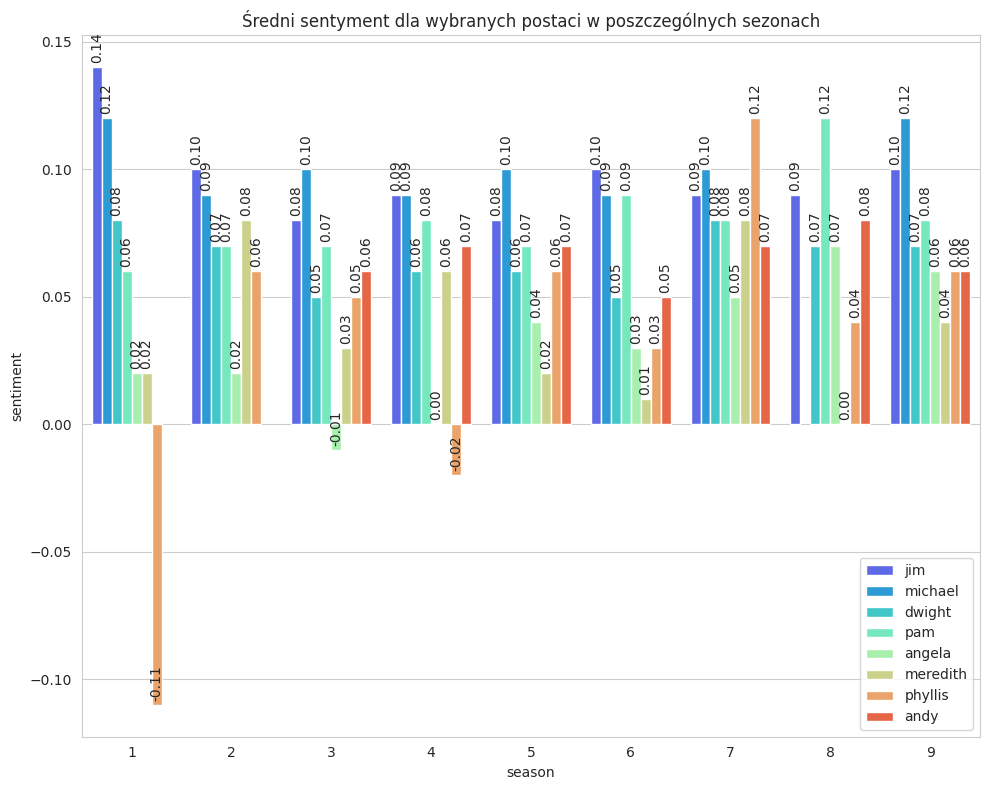

In [ ]:
#Posortowanie danych
sorted_data = character_sentiment.sort_values(by=['season', 'sentiment'], ascending=[True, False])

#Uworzenie wykresu słupkowego dla każdej postaci
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(data=sorted_data, x='season', y='sentiment', hue='speaker', palette = 'rainbow')

# Dodanie etykiet dla słupków
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', xy=(p.get_x() + p.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', rotation=90)

# Dodanie legendy, tytułu wykresu i siatki
ax.legend()
ax.set_title('Średni sentyment dla wybranych postaci w poszczególnych sezonach')
ax.yaxis.grid(True)

# Wyświetlenie wykresu
plt.tight_layout()
plt.show()

Jak widać na wykresie, średnia wypowiedzi wszystkich postaci oscyluje w okolicach zera - czyli wypowiedzi nacechowanych neutralnie. Nie zaskakuje to specjalnie - serial w założeniu miał imitować życie prawdziwych osób pracujących w biurze. Żadna z postaci nie była ani czarnym charakterem ani nieskazitelnym bohaterem.
Sprawdziłam jeszcze, dla których postaci zaobserwowano najwyższą i najniższą wartość sentymentu w każdym z sezonów.

In [ ]:
# Grupowanie danych po sezonie i wybór postaci (z 8 wcześniej wybranych) z najwyższą i najniższą wartością sentymentu
max_sentiment_characters = sorted_data.loc[sorted_data.groupby('season')['sentiment'].idxmax()]
min_sentiment_characters = sorted_data.loc[sorted_data.groupby('season')['sentiment'].idxmin()]

# Uworzenie ramki danych wskazującej postać o najwyższym sentymencie dla poszczególnych sezonów
max_sentiment_table = pd.DataFrame(max_sentiment_characters[['season', 'speaker', 'sentiment']])
max_sentiment_table = max_sentiment_table.set_index('season')

# Wyświetlenie ramki danych wskazującej postać o najwyższym sentymencie dla poszczególnych sezonów
print("Postacie z najwyższą wartością sentymentu:")
max_sentiment_table

Postacie z najwyższą wartością sentymentu:


,speaker,sentiment
season,,
1,jim,0.14
2,jim,0.10
3,michael,0.10
4,jim,0.09
5,michael,0.10
6,jim,0.10
7,phyllis,0.12
8,pam,0.12
9,michael,0.12


Obliczenia wskazują, że postaciami najbardziej pozytywnymi spośród wybranych postaci jest Jim i Michael.

In [ ]:
# Tworzenie ramki danych wskazującej postać o najniższym sentymencie dla poszczególnych sezonów
min_sentiment_table = pd.DataFrame(min_sentiment_characters[['season', 'speaker', 'sentiment']])
min_sentiment_table = min_sentiment_table.set_index('season')

# Wyświetlenie ramki danych wskazującej postać o najniższym sentymencie dla poszczególnych sezonów
print("\nPostacie z najniższą wartością sentymentu:")
min_sentiment_table


Postacie z najniższą wartością sentymentu:


,speaker,sentiment
season,,
1,phyllis,-0.11
2,angela,0.02
3,angela,-0.01
4,phyllis,-0.02
5,meredith,0.02
6,meredith,0.01
7,angela,0.05
8,meredith,0.00
9,meredith,0.04


Jeśli chodzi o postacie, których wypowiedzi miały najbardziej negatywny wydźwięk, w zestawieniu najczęściej pojawia się Meredith, jednak najniższy wynik osiągnęła Phyllis (ciekawe jest jednak to, że w sezonie 7 miała ona najbardziej pozytywne kwestie).

Oceniłam również rozkład sentymentu; poniżej widoczny jest histogram:

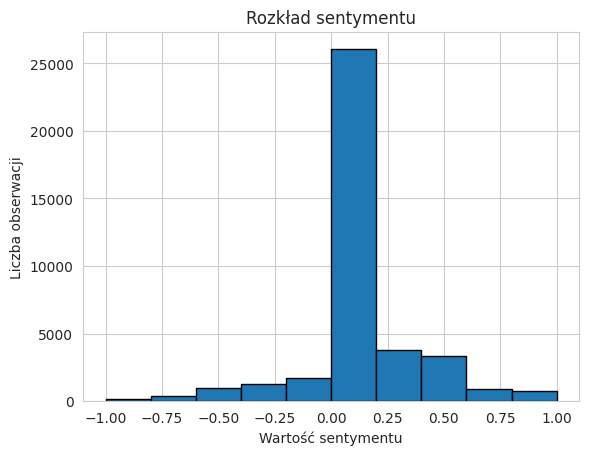

In [ ]:
# Tworzenie histogramu sentymentu
plt.hist(dialogues['sentiment'], bins=10, edgecolor='black')

# Dodanie tytułu i etykiet osi
plt.title('Rozkład sentymentu')
plt.xlabel('Wartość sentymentu')
plt.ylabel('Liczba obserwacji')

# Wyświetlenie histogramu
plt.show()

Histogram jest lekko przesunięty w prawo, co wskazuje, że chociaż wypowiedzi bohaterów są w dużej mierze neutralne, mają zabarwienie bardziej pozytywne, niż negatywne.

Postanowiłam jeszcze sprawdzić, jak prezentuje się procentowy udział wypowiedzi nacechowanych pozytywnie, negatywnie i neutralnie względem łącznej liczby kwestii wypowiadanych przez wybrane przeze mnie postaci. Za wypowiedzi neutralne przyjęłam kwestie o wartości sentymentu równej 0, negatywne o wartości mniejszej od 0, a pozytywne o wartości większej od 0.

In [ ]:
# Wyodrębnienie wierszy z sentymentem pozytywnym
positive_dialogues = dialogues.loc[(dialogues['sentiment'] >0)]

# Wyodrębnienie wierszy z sentymentem negatywnym
negative_dialogues = dialogues.loc[(dialogues['sentiment'] <0)]

# Wyodrębnienie wierszy z sentymentem neutralnym
neutral_dialogues = dialogues.loc[(dialogues['sentiment'] == 0)]

# Obliczenie liczby wypowiedzi pozytywnych, negatywnych i neutralnych dla każdej postaci
positive_counts = positive_dialogues['speaker'].value_counts()
negative_counts = negative_dialogues['speaker'].value_counts()
neutral_counts = neutral_dialogues['speaker'].value_counts()
total_counts = positive_counts.values + negative_counts.values + neutral_counts.values

# Obliczenie procentowego udziału wypowiedzi pozytywnych i negatywnych dla każdej postaci
positive_percentages = ((positive_counts / total_counts) * 100).round(2)
negative_percentages = ((negative_counts / total_counts) * 100).round(2)

#Utworzenie nowej ramki danych z wynikami
result_df = pd.DataFrame({
    'speaker': positive_percentages.index,
    'negative': negative_percentages.values,
    'positive': positive_percentages.values
    })

# Obliczanie wyników dla wypowiedzi neutralnych
result_df['neutral'] = 100 - (result_df['positive'] + result_df['negative'])
result_df

,speaker,negative,positive,neutral
0,michael,11.17,35.93,52.90
1,jim,11.73,30.19,58.08
2,dwight,10.40,32.63,56.97
3,pam,10.59,30.50,58.91
4,andy,13.23,31.49,55.28
5,angela,13.22,22.36,64.42
6,phyllis,12.04,24.09,63.87
7,meredith,12.40,25.12,62.48


Przedstawiłam jeszcze uzyskane wartości na wykresie słupkowym:

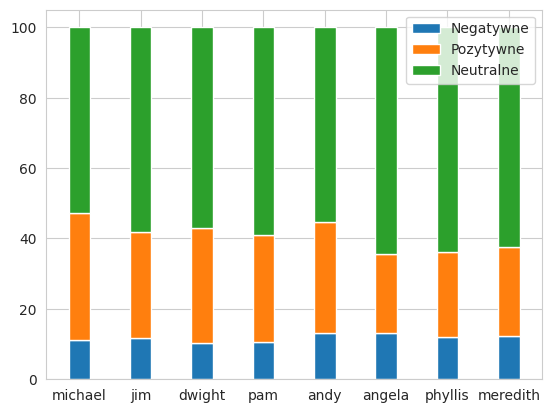

In [ ]:
# Tworzenie indeksu dla osi x
x = np.arange(len(result_df))

# Szerokość pojedynczego słupka
width = 0.35

# Utworzenie wykresu słupkowego
fig, ax = plt.subplots()
rects1 = ax.bar(x, result_df['negative'], width, label='Negatywne')
rects2 = ax.bar(x, result_df['positive'], width, bottom=result_df['negative'], label='Pozytywne')
rects3 = ax.bar(x, result_df['neutral'], width, bottom=result_df['negative']+result_df['positive'], label='Neutralne')

# Ustawienie etykiet na osi x + dodanie legendy
ax.set_xticks(x)
ax.set_xticklabels(result_df['speaker'])
ax.legend()

# Wyświetlenie wykresu
plt.show()

Jak widać, u przeważającej liczby postaci zdecydowanie dominują wypowiedzi o zabarwieniu neutralnym - we wszystkich przypadkach przekraczają one 50%. U żadnej postaci odsetek wypowiedzi negatywnych nie przekracza 14%. Najwyższy odsetek wypowiedzi pozytywnych odnotowano dla Michaela Scotta - prawie 36%, natomiast najniższy dla Angeli - 22,36%.

# Wnioski

Przeprowadzona przez mnie analiza danych wskazuje, że grana przez Steve'a Carella postać Michaela Scotta miała niezwykle duży wpływ na odbiór serialu. Ze zgromadzonych danych wynika, że Michael Scott był postacią, która wypowiedziała najwięcej słów i kwestii w całym serialu "The Office". Jego charakterystyczny styl komunikacji, pełen humoru, niekiedy kontrowersji i nietypowych żartów, przyczynił się do wyjątkowej dynamiki i atrakcyjności serialu.
Po wykluczeniu z serialu Steve'a Carella oglądalność serialu znacząco spadła. Sugeruje to, że jego obecność była kluczowym czynnikiem przyciągającym widzów i utrzymującym ich zainteresowanie.
Michael był bardzo barwną postacią - miał skłonność do przesadnych reakcji, był w stanie przejść od skrajnej euforii do przygnębienia w bardzo krótkim czasie. Ponadto, Michael nie był stereotypowym wszystkowiedzącym szefem - często stawał w obliczu niekomfortowych sytuacji, takich jak konflikty ze współpracownikami, trudności w zarządzaniu zespołem czy problemy w nawiązywaniu relacji, co sprawiło, że jego postać była bardziej "żywa".
W rezultacie, mimo że Michael Scott czasami zachowywał się nieodpowiednio i kontrowersyjnie, był pozytywną postacią, z którą widzowie nawiązali dość silną więź emocjonalną.
Gdy producenci serialu nie zaproponowali Steve'owi Carellowi przedłużenia kontraktu, wielu widzów przestało oglądać tę produkcję, gdyż bez tej postaci serial wydawał się pusty.